In [2]:
import importlib
import volpy_func_lib as vp
import load_clean_lib
import table_lib
import vol_strat_lib as vs
import option_returns as orpy
from global_settings import *
import pandas as pd
import numpy as np
import cor_lib
import volpy_func_ticker_lib as vtp

importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(vs)
importlib.reload(orpy)
importlib.reload(vtp)
importlib.reload(cor_lib)

c:\Users\axell\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<module 'cor_lib' from 'c:\\Users\\axell\\Desktop\\CBS\\master\\volpy\\cor_lib.py'>

In [6]:
od = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\Tickers\Output\t_\DIS\od_raw.csv")

In [13]:
# 1. Filtrer på den ønskede dato
filtered = od[od["date"] == "1996-01-08"]

# 2. Grupér efter t_days og tæl unikke K
unique_K_per_tday = filtered.groupby("t_days")["K"].nunique().reset_index()

# 3. Giv evt. kolonnen et nyt navn
unique_K_per_tday.columns = ["t_days", "unique_K_count"]

# 4. Vis resultatet
print(unique_K_per_tday)


   t_days  unique_K_count
0     9.0               7
1    29.0               8
2    72.0               4
3    92.0               5
4   135.0               4


### import crsp data, constituents and map constituents to crsp data and select constituents

In [2]:
importlib.reload(cor_lib)
constituents_long, daily_returns_constituents = cor_lib.get_index_constituents_and_returns("INDU")

Fil fundet: C:\Users\axell\Desktop\CBS\data\OptionMetrics\Tickers\cor metadata\daily_returns_indu.csv – loader den i stedet.


### number of constituents with data over time 

Mindste antal aktiver på en dag: 22


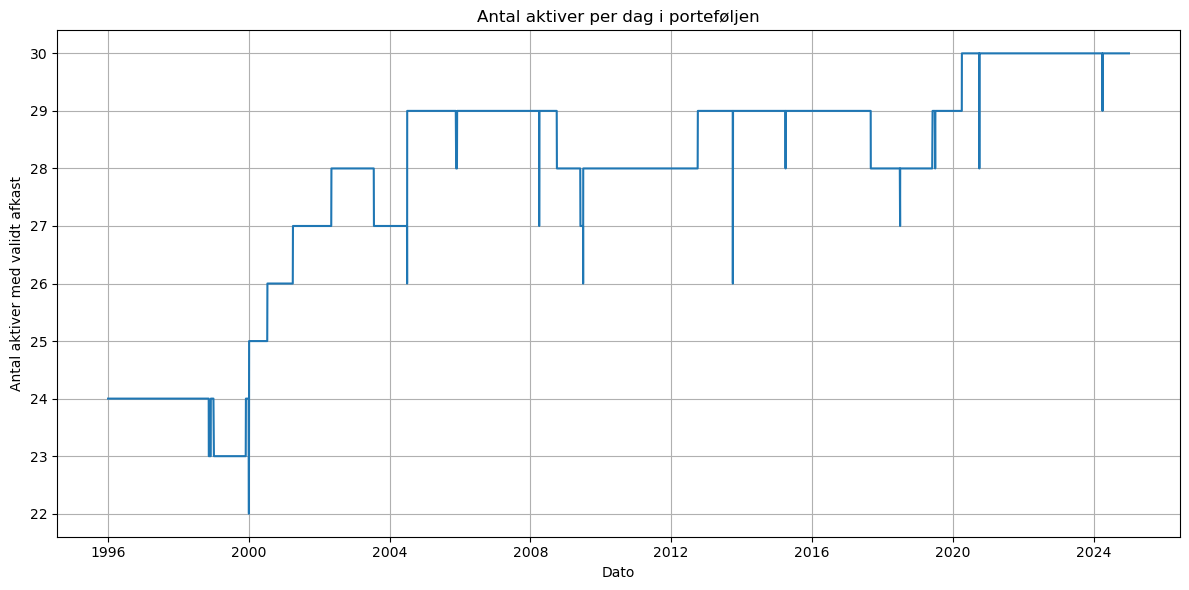

In [3]:
import matplotlib.pyplot as plt

# Tæl antal aktiver (ikke-NaN returns) per dag
assets_per_day = daily_returns_constituents.groupby("date")["return"].count()

# Udskriv mindste antal aktiver
print(f"Mindste antal aktiver på en dag: {assets_per_day.min()}")

# Plot antal aktiver over tid
plt.figure(figsize=(12,6))
plt.plot(assets_per_day.index, assets_per_day.values)
plt.xlabel("Dato")
plt.ylabel("Antal aktiver med validt afkast")
plt.title("Antal aktiver per dag i porteføljen")
plt.grid(True)
plt.tight_layout()
plt.show()


### calculate index returns

In [4]:
importlib.reload(cor_lib)
replicated_returns_daily = cor_lib.get_replicated_index_returns(daily_returns_constituents)

### get true index returns from index data (bloom) and merge to complete df

In [5]:
importlib.reload(cor_lib)
index_daily_returns_df = cor_lib.add_return_true(replicated_returns_daily, ticker = "INDU")

### add variance components to index_df - decomposing variance

In [6]:
import pandas as pd
import numpy as np

def decompose_variance_flexible_weights(
    df: pd.DataFrame,
    window: int = 30,
    average_weights: bool = True,
    mean_method: str = "equal",  # 'equal' eller 'weighted'
    min_pct: float = 0.8
) -> pd.DataFrame:
    """
    Dekomponér rullede variance- og covariance-komponenter vha. fleksible vægte.

    Parametre:
    - df: DataFrame med ["date","ticker","return","weight_lag"]
    - window: rullevindue (dage)
    - average_weights: True -> gennemsnitsvægte, False -> vægte fra sidste dag
    - mean_method: 'equal' eller 'weighted' for beregning af både sigma_mean og rho_mean
    - min_pct: minimum % af dage en ticker skal have retur i vinduet

    Returnerer for hver dato:
      - vol_variance_component
      - vol_covariance_component
      - vol_total_reconstructed
      - rho_mean
      - sigma_mean
      - n_assets_used
      - n_days_used
    """
    df = df.sort_values(["date", "ticker"])
    dates = df["date"].drop_duplicates().sort_values().to_list()

    R = df.pivot(index="date", columns="ticker", values="return")
    W = df.pivot(index="date", columns="ticker", values="weight_lag")

    out = []
    req = int(np.ceil(window * min_pct))

    for i in range(window, len(dates)):
        dt  = dates[i]
        win = dates[i-window : i]

        r_win = R.loc[win]
        w_win = W.loc[win]

        # 1) filtrér tickers med utilstrækkelig data
        valid = r_win.columns[r_win.notna().sum() >= req]
        if len(valid) < 2:
            continue

        r_sel = r_win[valid].dropna(axis=0)
        w_sel = w_win[valid].loc[r_sel.index]

        n_days = len(r_sel)
        if n_days < 2:
            continue

        # 2) vægte
        w_ts = w_sel.mean(axis=0) if average_weights else w_sel.iloc[-1]

        # 3) beregn sigma og corr
        sigma_t = r_sel.std(ddof=0)
        corr_t  = r_sel.corr()

        # 4) trim til tickers med positiv sigma
        ok = sigma_t.index[sigma_t > 0]
        if len(ok) < 2:
            continue

        wv = w_ts[ok].values
        sv = sigma_t[ok].values
        Cv = corr_t.loc[ok,ok].values

        # 5) variance‐komponenter
        ws = wv * sv
        var_diag    = np.sum((wv**2) * (sv**2))
        var_offdiag = np.sum(np.outer(ws, ws) * Cv) - np.sum(ws**2)
        var_tot     = var_diag + var_offdiag

        # 6) sigma_mean
        if mean_method == "equal":
            sigma_mean = sv.mean()
        else:  # weighted
            # normaliser vægte
            w_norm = wv / wv.sum()
            sigma_mean = np.dot(w_norm, sv)

        # 7) rho_mean
        mask = ~np.eye(len(ok), dtype=bool)
        if mean_method == "equal":
            rho_mean = Cv[mask].mean()
        else:
            # vægtet gennemsnit af off‐diag elementer
            # lav matrix af wv[i]*wv[j]
            W2 = np.outer(wv, wv)
            rho_sum = np.sum(W2[mask] * Cv[mask])
            rho_mean = rho_sum / np.sum(W2[mask])

        out.append({
            "date":                     dt,
            "vol_variance_component":   np.sqrt(var_diag    * 252),
            "vol_covariance_component": np.sqrt(var_offdiag * 252),
            "vol_total_reconstructed":  np.sqrt(var_tot     * 252),
            "rho_mean":                 rho_mean,
            "sigma_mean":               sigma_mean,
            "n_assets_used":            len(ok),
            "n_days_used":              n_days
        })

    return pd.DataFrame(out)


def add_all_variance_components(
    index_df: pd.DataFrame,
    constituents_df: pd.DataFrame,
    window: int = 30,
    average_weights: bool = True,
    mean_method: str = "equal",
    min_pct: float = 0.8
) -> pd.DataFrame:
    """
    Tilføj alle volatility‐kolonner til index_df:
      - vol_rolling_true
      - vol_rolling_replicated
      - vol_variance_component
      - vol_covariance_component
      - vol_total_reconstructed
      - rho_mean
      - sigma_mean
      - n_assets_used
      - n_days_used
    """
    idx = index_df.copy()
    idx["date"] = pd.to_datetime(idx["date"])
    idx["vol_rolling_true"]       = (
        idx["return_true"]
        .rolling(window)
        .std(ddof=0)
        * np.sqrt(252)
    )
    idx["vol_rolling_replicated"] = (
        idx["return_replicated"]
        .rolling(window)
        .std(ddof=0)
        * np.sqrt(252)
    )

    var_corr_df = decompose_variance_flexible_weights(
        constituents_df,
        window=window,
        average_weights=average_weights,
        mean_method=mean_method,
        min_pct=min_pct
    )
    var_corr_df["date"] = pd.to_datetime(var_corr_df["date"])

    return idx.merge(var_corr_df, on="date", how="left")


# Eksempel på kørsel:
index_df = add_all_variance_components(
    index_daily_returns_df,
    daily_returns_constituents,
    window=21*3,
    average_weights=False,
    mean_method="weighted",   # 'equal' eller 'weighted'
    min_pct=0.9
)


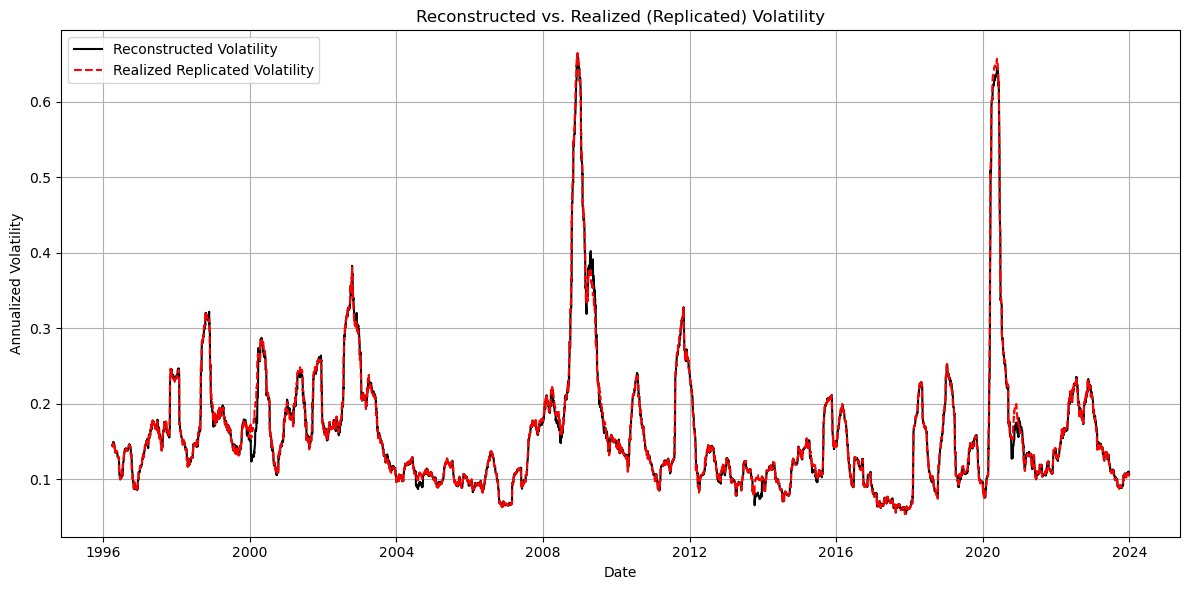

In [7]:
import matplotlib.pyplot as plt

def plot_reconstructed_vs_replicated_vol(df, start_date=None, end_date=None):
    # Filtrér datoer hvis angivet
    plot_df = df.copy()
    if start_date:
        plot_df = plot_df[plot_df["date"] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df["date"] <= pd.to_datetime(end_date)]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(plot_df["date"], plot_df["vol_total_reconstructed"], label="Reconstructed Volatility", color="black")
    plt.plot(plot_df["date"], plot_df["vol_rolling_replicated"], label="Realized Replicated Volatility", color="red", linestyle="--")
    
    plt.title("Reconstructed vs. Realized (Replicated) Volatility")
    plt.xlabel("Date")
    plt.ylabel("Annualized Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_reconstructed_vs_replicated_vol(index_df, start_date="1996-01-01", end_date="2023-12-31")


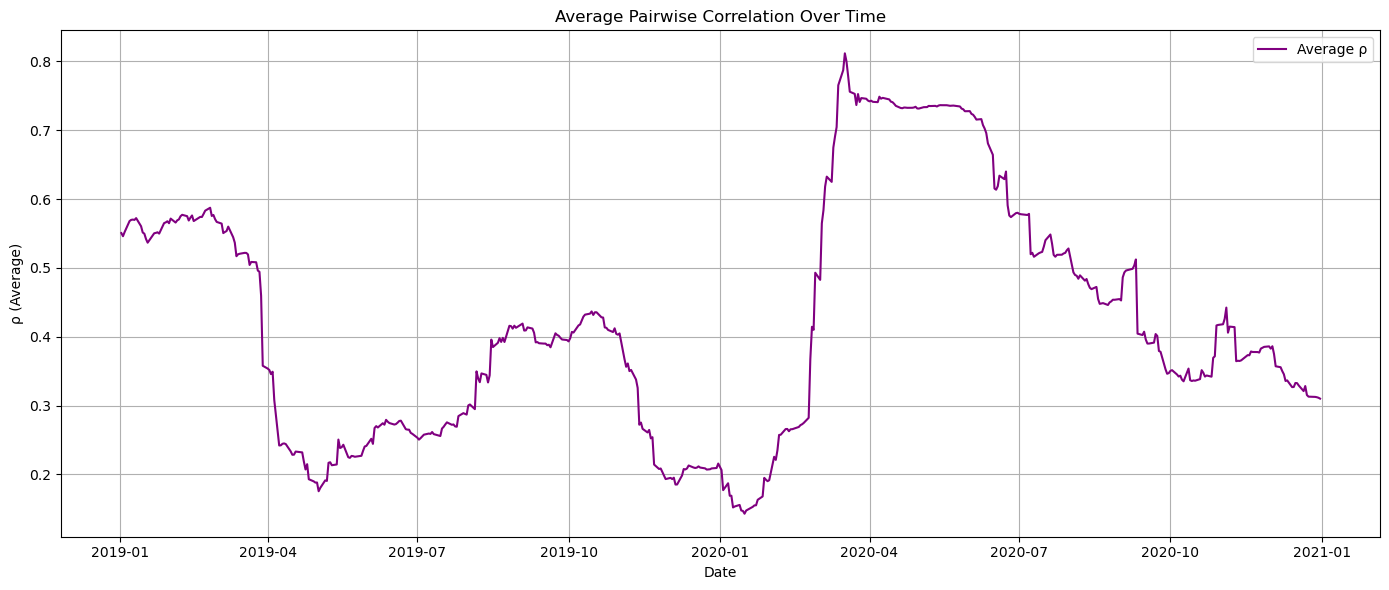

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_rho_mean(df, start_date=None, end_date=None):
    """
    Plots the rolling average pairwise correlation (rho_mean) over time.
    
    Parametre:
    - df         : DataFrame med mindst kolonnerne ['date','rho_mean']
    - start_date : (valgfri) streng "YYYY-MM-DD" for plotstart
    - end_date   : (valgfri) streng "YYYY-MM-DD" for plotslut
    """
    plot_df = df.copy()
    plot_df["date"] = pd.to_datetime(plot_df["date"])
    
    if start_date:
        plot_df = plot_df[plot_df["date"] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df["date"] <= pd.to_datetime(end_date)]
    
    plt.figure(figsize=(14, 6))
    plt.plot(plot_df["date"], plot_df["rho_mean"], color="purple", label="Average ρ")
    plt.title("Average Pairwise Correlation Over Time")
    plt.xlabel("Date")
    plt.ylabel("ρ (Average)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Eksempel på kald:
plot_rho_mean(index_df, start_date="2019-01-01", end_date="2021-01-01")


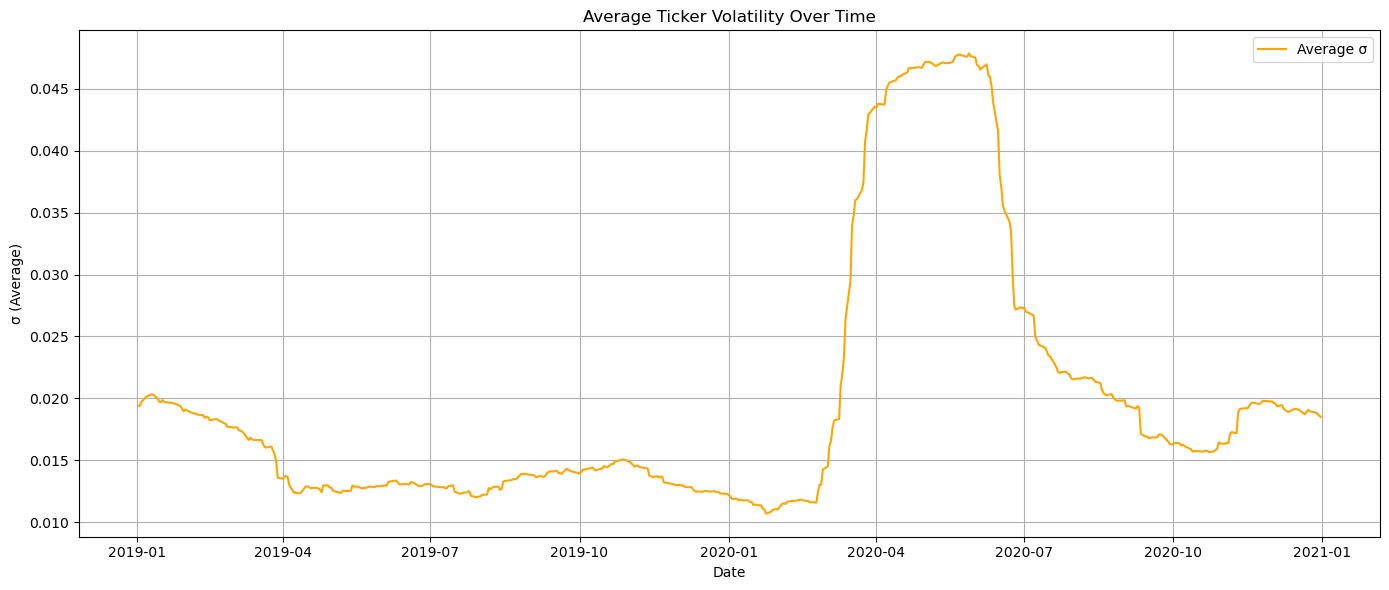

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sigma_mean(df, start_date=None, end_date=None):
    """
    Plots the rolling average ticker volatility (sigma_mean) over time.
    
    Parametre:
    - df         : DataFrame med mindst kolonnerne ['date','sigma_mean']
    - start_date : (valgfri) streng "YYYY-MM-DD" for plotstart
    - end_date   : (valgfri) streng "YYYY-MM-DD" for plotslut
    """
    plot_df = df.copy()
    plot_df["date"] = pd.to_datetime(plot_df["date"])
    
    if start_date:
        plot_df = plot_df[plot_df["date"] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df["date"] <= pd.to_datetime(end_date)]
    
    plt.figure(figsize=(14, 6))
    plt.plot(plot_df["date"], plot_df["sigma_mean"], color="orange", label="Average σ")
    plt.title("Average Ticker Volatility Over Time")
    plt.xlabel("Date")
    plt.ylabel("σ (Average)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Eksempel på kald:
plot_sigma_mean(index_df, start_date="2019-01-01", end_date="2021-01-01")


### decomp off diagonal variance with fixed "counterpart" 

In [10]:
import pandas as pd
import numpy as np

def decompose_total_variance_fixed_elements_v3(
    df: pd.DataFrame,
    window: int = 30,
    fix_to_constant: bool = False,
    min_pct: float = 0.8,
    min_obs: int = 20
) -> pd.DataFrame:
    """
    Version 3: Samme som v2, men TOTAL_VARIANS (= vol_total_reconstructed)
    og de faste komponenter beregnes *kun på off‐diagonal* (altså uden idiosynkratisk/diagonal‐risk).

    Parametre:
    - df: DataFrame med ["date","ticker","return","weight_lag"]
    - window: rullevindue i dage
    - fix_to_constant: True -> brug konstante σ̄ og ρ̄ ved off‐diag‐beregningen
    - min_pct: min % af dage en ticker skal have data i vinduet
    - min_obs: min antal fælles dage for at en par‐vis ρ/σ tæller med i fixed‐værdier
    """
    df = df.sort_values(["date", "ticker"])
    dates = df["date"].drop_duplicates().sort_values().to_list()

    # Pivotér returns og laggede vægte
    R = df.pivot(index="date", columns="ticker", values="return")
    W = df.pivot(index="date", columns="ticker", values="weight_lag")

    # Build matrix over fælles observationer
    present = R.notna().astype(int)
    counts  = present.T.dot(present)

    # Rå kovarianser/korrelationer
    raw_cov  = R.cov()
    raw_corr = R.corr()

    # Maskér fixed‐parametre ved min_obs
    fixed_cov  = raw_cov.where(counts >= min_obs)
    fixed_corr = raw_corr.where(counts >= min_obs)

    # Udtræk faste σ fra diagonalen af fixed_cov
    fixed_sigma = pd.Series(
        np.sqrt(np.diag(fixed_cov.values)),
        index=fixed_cov.index
    )

    # Globale gennemsnit, hvis vi fikser konstant
    if fix_to_constant:
        sigma_bar = fixed_sigma.mean()
        rho_bar   = fixed_corr.stack().mean()

    out = []
    req = int(np.ceil(window * min_pct))

    for i in range(window, len(dates)):
        dt  = dates[i]
        win = dates[i-window : i]

        r_win = R.loc[win]
        w_win = W.loc[win]

        # 1) filtrér tickers med for få dage
        valid = r_win.columns[r_win.notna().sum() >= req]
        if len(valid) < 2:
            continue

        # 2) drop days with any NaN in these tickers
        r_sel = r_win[valid].dropna(axis=0)
        w_sel = w_win[valid].loc[r_sel.index]
        n_days = len(r_sel)
        if n_days < 2:
            continue

        # 3) vægte fra sidste dag
        w_t = w_sel.iloc[-1]

        # 4) population σ og ρ på renset data
        sigma_t = r_sel.std(ddof=0)
        corr_t  = r_sel.corr()

        # Tickere med positiv σ
        ok = sigma_t.index[sigma_t > 0]
        if len(ok) < 2:
            continue

        # Arrays
        wv = w_t[ok].values
        sv = sigma_t[ok].values
        Cv = corr_t.loc[ok, ok].values
        fsv = fixed_sigma[ok].values
        fcv = fixed_corr.loc[ok, ok].values

        if fix_to_constant:
            fsv[:] = sigma_bar
            fcv[:] = rho_bar
            np.fill_diagonal(fcv, 1.0)

        # Byg covariance matricer
        cov_t    = np.outer(sv,    sv)    * Cv
        cov_fsig = np.outer(fsv,   fsv)   * Cv
        cov_frho = np.outer(sv,    sv)    * fcv

        # Beregn bidrag
        # diag‐bidrag, som vi nu vil ekskludere:
        var_diag = np.sum((wv**2) * (sv**2))

        # off‐diag‐bidrag:
        var_offdiag      = np.dot(wv, cov_t    @ wv) - var_diag
        var_offdiag_sig  = np.dot(wv, cov_fsig @ wv) - np.sum((wv**2) * (fsv**2))
        var_offdiag_rho  = np.dot(wv, cov_frho @ wv) - var_diag  # diag for cov_frho = sv^2

        out.append({
            "date":                    dt,
            # kun off‐diag bidrag annualiseret:
            "vol_total_reconstructed": np.sqrt(max(0, var_offdiag     * 252)),
            "vol_total_fixed_sigma":   np.sqrt(max(0, var_offdiag_sig * 252)),
            "vol_total_fixed_rho":     np.sqrt(max(0, var_offdiag_rho * 252)),
            "n_assets_used":           len(ok),
            "n_days_used":             n_days
        })

    return pd.DataFrame(out)


# Eksempel på kørsel:
decomp_df = decompose_total_variance_fixed_elements_v3(
    daily_returns_constituents,
    window=21*3,
    fix_to_constant=True,
    min_pct=0.9,
    min_obs=20
)


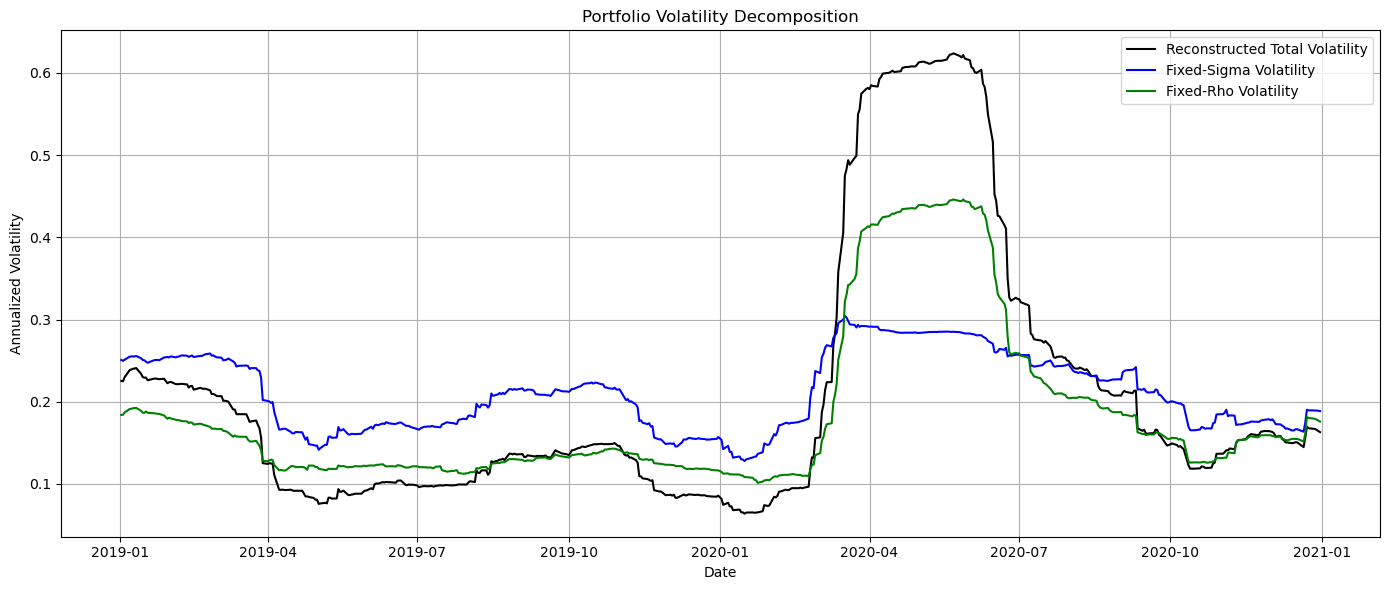

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_volatility_decomposition(
    df: pd.DataFrame,
    start_date: str = None,
    end_date:   str = None
):
    plot_df = df.copy()
    plot_df['date'] = pd.to_datetime(plot_df['date'])

    if start_date:
        plot_df = plot_df[plot_df['date'] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df['date'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(14, 6))
    plt.plot(
        plot_df['date'],
        plot_df['vol_total_reconstructed'],
        label='Reconstructed Total Volatility',
        color='black'
    )
    plt.plot(
        plot_df['date'],
        plot_df['vol_total_fixed_sigma'],
        label='Fixed‐Sigma Volatility',
        color='blue'
    )
    plt.plot(
        plot_df['date'],
        plot_df['vol_total_fixed_rho'],
        label='Fixed‐Rho Volatility',
        color='green'
    )

    plt.title('Portfolio Volatility Decomposition')
    plt.xlabel('Date')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_volatility_decomposition(decomp_df, start_date="2019-01-01", end_date="2021-01-01")


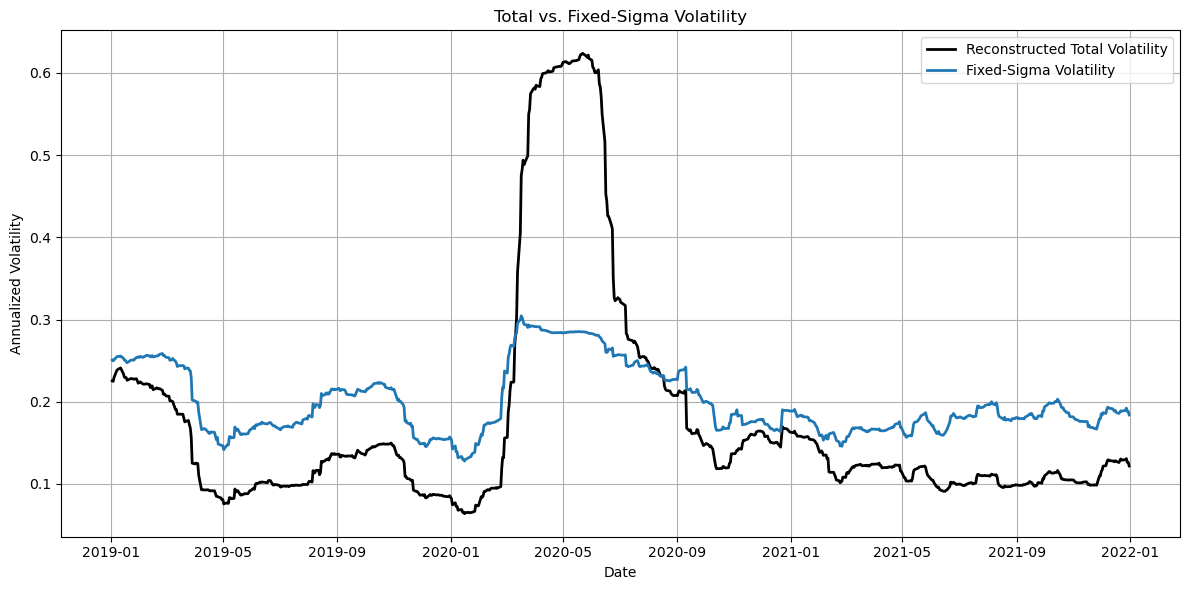

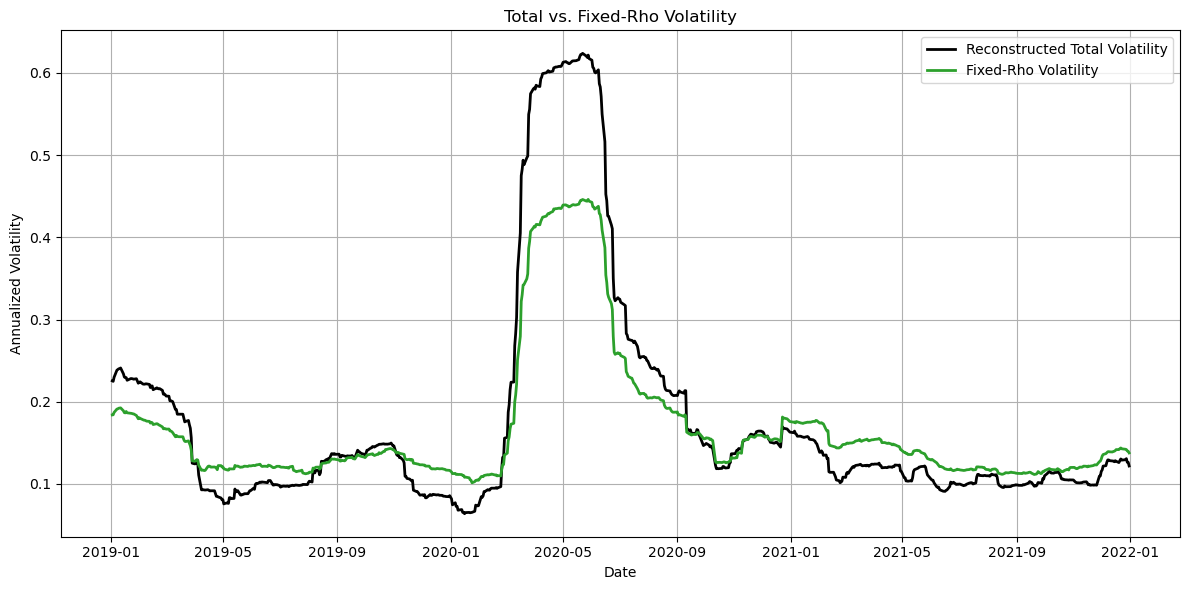

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_total_vs_fixed(
    df: pd.DataFrame,
    fixed_col: str,
    fixed_label: str,
    start_date: str = None,
    end_date: str = None
):
    """
    Plot Total vs. én af de faste volatilitetserier.

    Args:
      df           : DataFrame med kolonner ['date','vol_total_reconstructed', fixed_col]
      fixed_col    : kolonnenavn for fixed‐serie (f.eks. 'vol_total_fixed_sigma')
      fixed_label  : etiketten i legend (f.eks. 'Fixed‐Sigma Volatility')
      start_date   : (valgfrit) ISO‐string ’YYYY‐MM‐DD’
      end_date     : (valgfrit) ISO‐string ’YYYY‐MM‐DD’
    """
    plot_df = df.copy()
    plot_df["date"] = pd.to_datetime(plot_df["date"])
    if start_date:
        plot_df = plot_df[plot_df["date"] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df["date"] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12,6))
    plt.plot(
        plot_df["date"],
        plot_df["vol_total_reconstructed"],
        label="Reconstructed Total Volatility",
        color="black",
        lw=2
    )
    plt.plot(
        plot_df["date"],
        plot_df[fixed_col],
        label=fixed_label,
        color="tab:blue" if "sigma" in fixed_col else "tab:green",
        lw=2
    )

    plt.title(f"Total vs. {fixed_label}")
    plt.xlabel("Date")
    plt.ylabel("Annualized Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_both_decompositions(
    df: pd.DataFrame,
    start_date: str = None,
    end_date: str = None
):
    """
    Laver to plots i træk:
      1) Total vs. Fixed‐Sigma
      2) Total vs. Fixed‐Rho
    """
    # 1) Total vs. sigma
    plot_total_vs_fixed(
        df,
        fixed_col="vol_total_fixed_sigma",
        fixed_label="Fixed‐Sigma Volatility",
        start_date=start_date,
        end_date=end_date
    )

    # 2) Total vs. rho
    plot_total_vs_fixed(
        df,
        fixed_col="vol_total_fixed_rho",
        fixed_label="Fixed‐Rho Volatility",
        start_date=start_date,
        end_date=end_date
    )

# Antag decomp_df er det du fik fra decompose_total_variance_fixed_elements(...)
plot_both_decompositions(
    decomp_df,
    start_date="2019-01-01",
    end_date="2021-12-31"
)


### rolling correlations

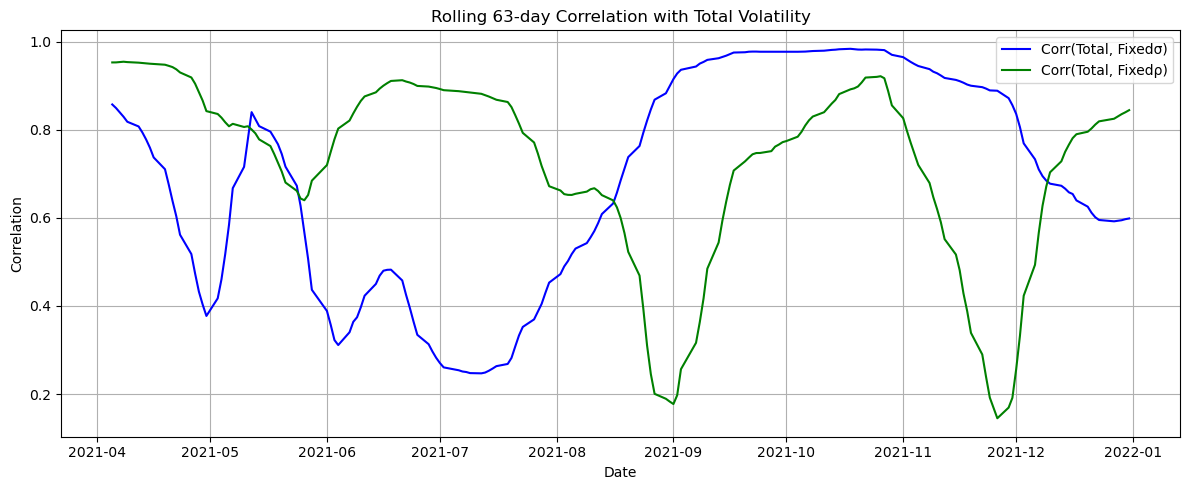

In [13]:
def plot_rolling_corr(df, window=21*3, from_date='1996-01-01', to_date='2023-12-31'):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])

    # Filtrér på datoer hvis angivet
    if from_date:
        from_date = pd.to_datetime(from_date)
        df = df[df['date'] >= from_date]
    if to_date:
        to_date = pd.to_datetime(to_date)
        df = df[df['date'] <= to_date]

    ts = df.set_index('date')[[
        'vol_total_reconstructed',
        'vol_total_fixed_sigma',
        'vol_total_fixed_rho'
    ]]

    corr_sig = ts['vol_total_reconstructed'].rolling(window).corr(ts['vol_total_fixed_sigma'])
    corr_rho = ts['vol_total_reconstructed'].rolling(window).corr(ts['vol_total_fixed_rho'])

    plt.figure(figsize=(12,5))
    plt.plot(corr_sig.index, corr_sig, label='Corr(Total, Fixedσ)', color='blue')
    plt.plot(corr_rho.index, corr_rho, label='Corr(Total, Fixedρ)', color='green')
    plt.title(f'Rolling {window}-day Correlation with Total Volatility')
    plt.xlabel('Date'); plt.ylabel('Correlation')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

plot_rolling_corr(decomp_df, window=21*3, from_date='2021-01-01', to_date='2021-12-31')


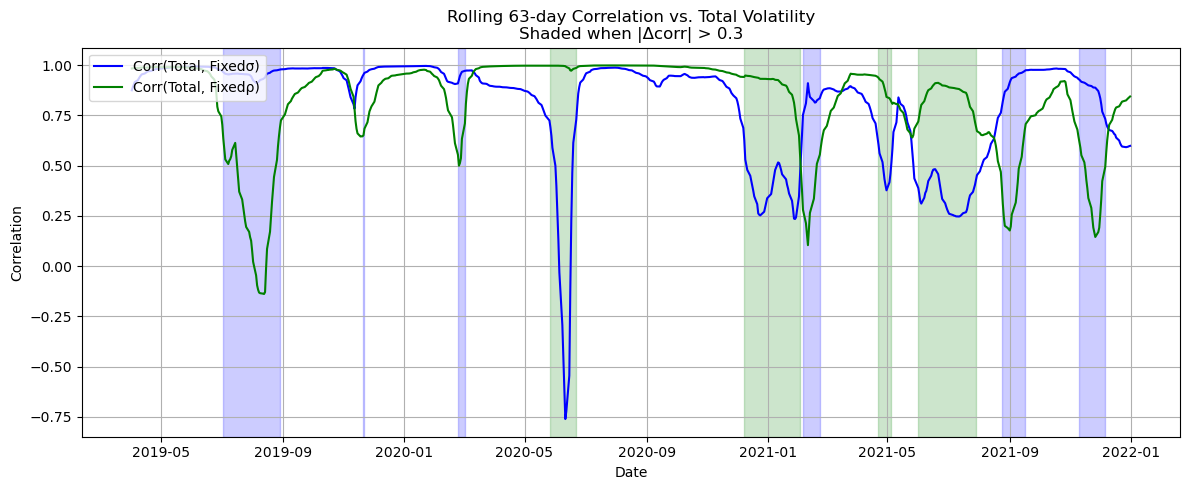

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_rolling_corr_with_shading(
    df: pd.DataFrame,
    window:     int    = 21*3,
    thresh:     float  = 0.3,
    from_date:  str    = None,
    to_date:    str    = None,
    alpha:      float  = 0.2
):
    """
    Plot rullende korrelation mellem total vol og fixed-σ / fixed-ρ.
    Skygger perioder hvor |corr_sig - corr_rho| > thresh,
    med blå baggrund hvis corr_sig > corr_rho, ellers grøn.
    """
    # Klargør data
    df2 = df.copy()
    df2['date'] = pd.to_datetime(df2['date'])
    if from_date:
        df2 = df2[df2['date'] >= pd.to_datetime(from_date)]
    if to_date:
        df2 = df2[df2['date'] <= pd.to_datetime(to_date)]
    ts = df2.set_index('date')[
        ['vol_total_reconstructed','vol_total_fixed_sigma','vol_total_fixed_rho']
    ]

    # Rullende korrelation
    corr_sig = ts['vol_total_reconstructed'].rolling(window).corr(ts['vol_total_fixed_sigma'])
    corr_rho = ts['vol_total_reconstructed'].rolling(window).corr(ts['vol_total_fixed_rho'])
    diff     = corr_sig - corr_rho

    # Plot basis
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(corr_sig.index, corr_sig, label='Corr(Total, Fixedσ)', color='blue')
    ax.plot(corr_rho.index, corr_rho, label='Corr(Total, Fixedρ)', color='green')

    # Helper til shading
    def shade_segments(mask, color):
        in_seg = False
        seg_start = None
        for dt, flag in mask.items():        # <-- brug items() her
            if flag and not in_seg:
                seg_start, in_seg = dt, True
            elif not flag and in_seg:
                ax.axvspan(seg_start, dt, color=color, alpha=alpha)
                in_seg = False
        if in_seg:
            ax.axvspan(seg_start, mask.index[-1], color=color, alpha=alpha)

    # Skift først perioder
    shade_segments(diff >  thresh, 'blue')
    shade_segments(diff < -thresh, 'green')

    ax.set_title(f"Rolling {window}-day Correlation vs. Total Volatility\nShaded when |Δcorr| > {thresh}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Correlation")
    ax.legend(loc="upper left")
    ax.grid(True)
    fig.tight_layout()
    plt.show()


# Eksempel på kald:
plot_rolling_corr_with_shading(
    decomp_df,
    window=21*3,
    thresh=0.3,
    from_date='2019-01-01',
    to_date='2021-12-31',
    alpha=0.2
)


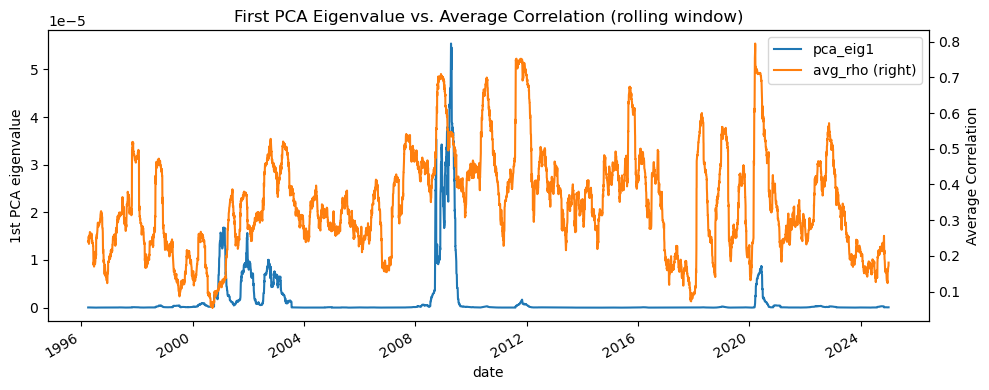

In [15]:
import numpy as np
from sklearn.decomposition import PCA

def rolling_pca_eigen(df_const, window=30):
    """
    Kør PCA på rullevinduer af cov(df) og returner 1. eigenværdi over tid.
    Samtidig beregner vi average pairwise correlation og plotter dem sammen.
    
    df_const    : daily_returns_constituents med ["date","ticker","return"]
    window      : rullevindue i dage
    """
    df_const = df_const.sort_values(["date","ticker"])
    dates = df_const["date"].drop_duplicates().sort_values().to_list()
    
    # pivot returns
    R = df_const.pivot(index="date", columns="ticker", values="return")
    
    records = []
    for i in range(window, len(dates)):
        win = dates[i-window:i]
        sub = R.loc[win].dropna(axis=1, how="any")  # drop tickers med NaN
        if sub.shape[1] < 2:
            continue
        
        # covariance matrix
        C = sub.cov().values
        
        # PCA
        pca = PCA(n_components=1)
        pca.fit(C)
        eig1 = pca.explained_variance_[0]
        
        # avg pairwise corr
        corr = sub.corr().values
        mask = np.triu(np.ones(corr.shape), 1).astype(bool)
        avg_rho = corr[mask].mean()
        
        records.append({
            "date": dates[i],
            "pca_eig1": eig1,
            "avg_rho": avg_rho
        })
    
    return pd.DataFrame(records).set_index("date")

# Eksempel:
pca_df = rolling_pca_eigen(daily_returns_constituents, window=21*3)

# Plot
ax = pca_df.plot(y=["pca_eig1","avg_rho"], secondary_y="avg_rho", figsize=(10,4))
ax.set_ylabel("1st PCA eigenvalue")
ax.right_ax.set_ylabel("Average Correlation")
ax.set_title("First PCA Eigenvalue vs. Average Correlation (rolling window)")
plt.tight_layout()
plt.show()


In [16]:
import statsmodels.api as sm

def rolling_variance_regression(index_df, df_const, window=30):
    """
    For hvert rullevindue regresser:
      σ²_market ~ α + β₁·avg_sigma² + β₂·avg_rho
    
    Returnerer tidsserie af β₁ og β₂.
    
    index_df   : DataFrame med ["date", "return_replicated"] → vi kan bygge σ²_market fra det
    df_const   : daily_returns_constituents med ["date","ticker","return"]
    window     : rullevindue i dage
    """
    # forbered markedets daily variance
    idx = index_df.copy()
    idx["date"] = pd.to_datetime(idx["date"])
    idx = idx.set_index("date")
    idx["var_market"] = idx["return_replicated"].rolling(window).var()
    
    # beregn avg_sigma² og avg_rho hver dag
    # (vi kan genbruge compute_avg_correlation + et simpelt sigma²-lookup)
    # men her laver vi et mini‐loop:
    df_const = df_const.sort_values(["date","ticker"])
    dates = idx.index.to_list()
    
    out = []
    for i in range(window, len(dates)):
        dt = dates[i]
        win = dates[i-window:i]
        
        sub = df_const[df_const["date"].isin(win)]
        R = sub.pivot(index="date", columns="ticker", values="return").dropna(axis=1, how="any")
        if R.shape[1] < 2:
            continue
        
        # avg sigma²
        avg_sigma2 = (R.std()**2).mean()
        
        # avg rho
        C = R.corr().values
        mask = np.triu(np.ones(C.shape),1).astype(bool)
        avg_rho = C[mask].mean()
        
        var_m = float(idx.loc[dt,"var_market"])
        out.append({"date": dt, "var_market": var_m,
                    "avg_sigma2": avg_sigma2, "avg_rho": avg_rho})
    
    reg_df = pd.DataFrame(out).set_index("date").dropna()
    
    # regressions på hele serien: men du kan også gøre det glidende med sm.OLS over sub‐vinduer
    X = reg_df[["avg_sigma2","avg_rho"]]
    X = sm.add_constant(X)
    y = reg_df["var_market"]
    model = sm.OLS(y, X).fit()
    print(model.summary())
    
    # returnér betas over tid (her blot én for hele perioden)
    return model.params, reg_df

# Eksempel:
params, reg_df = rolling_variance_regression(index_daily_returns_df, daily_returns_constituents, window=60)
print("Estimated β₁ (sigma²):", params["avg_sigma2"])
print("Estimated β₂ (rho):",   params["avg_rho"])


                            OLS Regression Results                            
Dep. Variable:             var_market   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Fri, 02 May 2025   Prob (F-statistic):               0.00
Time:                        00:43:19   Log-Likelihood:                 56028.
No. Observations:                7239   AIC:                        -1.120e+05
Df Residuals:                    7236   BIC:                        -1.120e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002   3.26e-06    -46.591      0.0

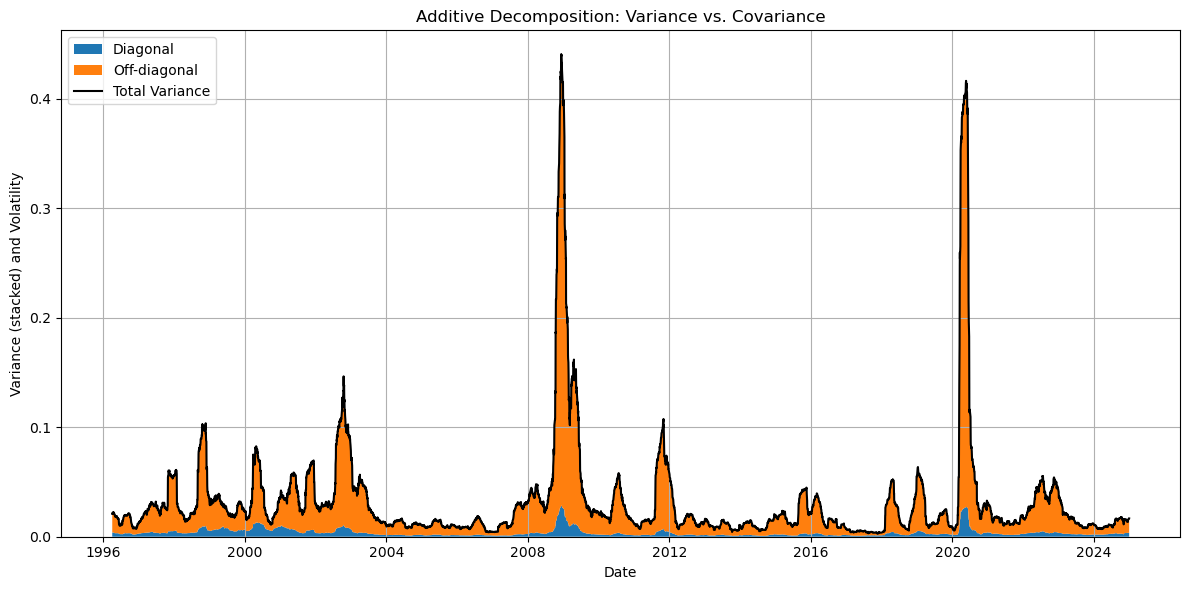

In [17]:
# Antag index_df har allerede dine vol-komponenter annualiseret:
v_var = index_df["vol_variance_component"] ** 2       # variance²
v_cov = index_df["vol_covariance_component"] ** 2     # covariance² (off-diagonal)

plt.figure(figsize=(12,6))
plt.stackplot(
    index_df["date"],
    v_var,
    v_cov,
    labels=["Diagonal", "Off-diagonal"],
    colors=["#1f77b4", "#ff7f0e"]
)
# Total volatilitet (σ) ovenpå:
plt.plot(
    index_df["date"],
    index_df["vol_total_reconstructed"]**2,
    color="black",
    label="Total Variance"
)

plt.title("Additive Decomposition: Variance vs. Covariance")
plt.xlabel("Date")
plt.ylabel("Variance (stacked) and Volatility")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


## plots of returns and vol of relicated vs actual index

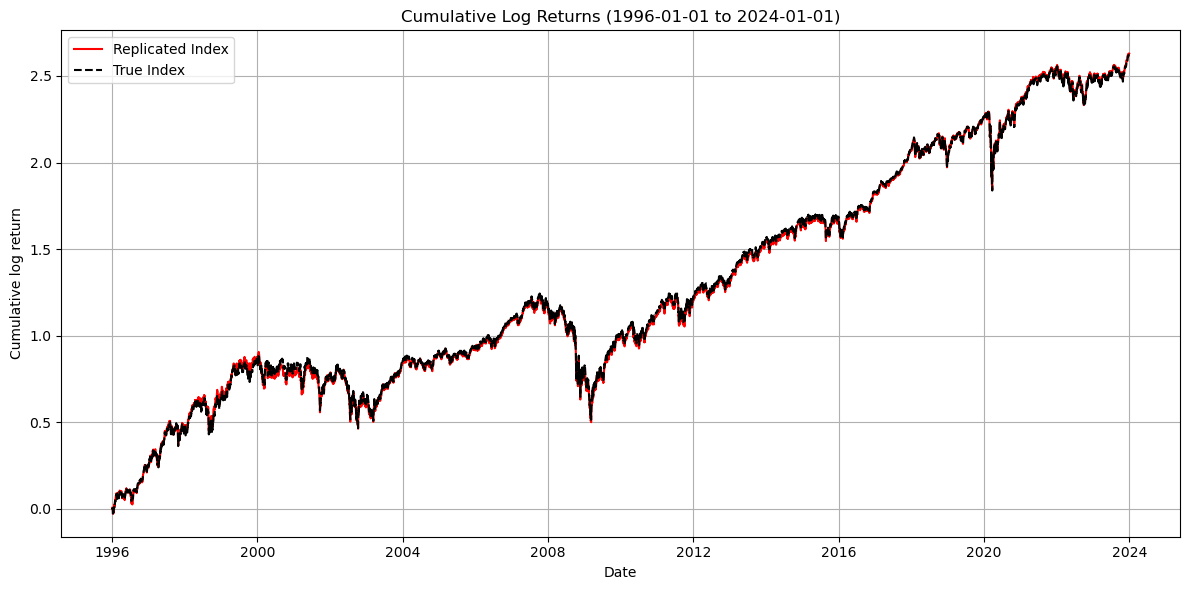

In [18]:
importlib.reload(cor_lib)
cor_lib.plot_log_cumulative_returns(index_daily_returns_df, "1996-01-01", "2024-01-01")


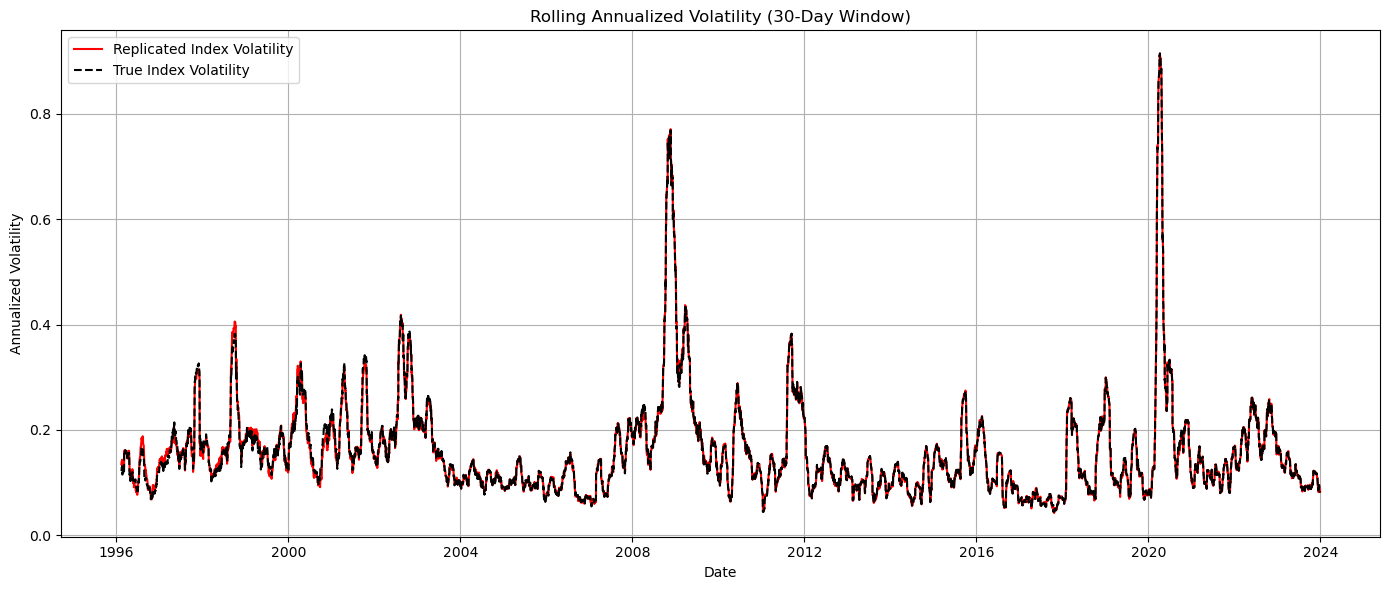

In [19]:
importlib.reload(cor_lib)
cor_lib.plot_rolling_volatility(index_daily_returns_df, "1996-01-01", "2024-01-01")


# Debug removed options 

In [63]:
ticker = "RTX"
od_debug = pd.read_csv(fr"C:\Users\axell\Desktop\CBS\data\OptionMetrics\Tickers\Debug\debug_rel_dev_filter_{ticker}.csv")
od_debug["date"] = pd.to_datetime(od_debug["date"])
od_debug[od_debug["remove"]].shape

(33, 13)

In [64]:
od_debug[od_debug["remove"]].sort_values("mid", ascending=False).head(20)

,optionid,date,exdate,cp_flag,F,K,mid,rel_dev,thr_dev,median_mid,flag1,flag2,remove
612566,133572747,2021-04-16,2021-06-18,P,77.635212,35.0,1.290,0.549174,0.291559,0.5450,True,True,True
583374,136282987,2020-10-21,2020-11-06,P,60.353303,45.0,1.285,0.254390,0.200000,0.5950,True,True,True
611583,139080269,2021-04-12,2021-05-21,C,78.490293,115.0,1.260,0.465149,0.242192,0.1825,True,True,True
610859,133572751,2021-04-07,2021-06-18,P,77.150374,55.0,1.210,0.287107,0.222298,0.4900,True,True,True
649225,142541266,2021-11-24,2022-05-20,C,85.879511,115.0,1.195,0.339085,0.309975,0.5675,True,True,True
612362,133572749,2021-04-15,2021-06-18,P,76.933305,45.0,1.150,0.415078,0.252599,0.4075,True,True,True
611629,133572749,2021-04-12,2021-06-18,P,77.644995,45.0,1.145,0.420439,0.259450,0.4225,True,True,True
651817,142541266,2021-12-15,2022-05-20,C,82.125497,115.0,1.125,0.400296,0.339414,0.4200,True,True,True
657158,140901807,2022-01-20,2022-02-18,P,87.884452,70.0,1.115,0.203500,0.200000,0.5100,True,True,True
583596,136282987,2020-10-22,2020-11-06,P,62.770113,45.0,1.100,0.283098,0.200000,0.4250,True,True,True


In [37]:
od_debug[(od_debug["date"]=="2020-03-18")&(od_debug["exdate"]=="2020-04-24")].sort_values("K",ascending=True)

,optionid,date,exdate,cp_flag,F,K,mid,rel_dev,thr_dev,median_mid,flag1,flag2,remove
455182,132948728,2020-03-18,2020-04-24,P,6.493215,2.0,1.395,0.691986,0.383972,0.555,True,True,True
455181,132948729,2020-03-18,2020-04-24,P,6.493215,2.5,0.085,0.614983,0.383972,0.555,True,False,False
455176,132948730,2020-03-18,2020-04-24,P,6.493215,3.0,0.145,0.537979,0.383972,0.555,True,False,False
455177,132843261,2020-03-18,2020-04-24,P,6.493215,4.0,0.305,0.383972,0.383972,0.555,True,False,False
455178,132805287,2020-03-18,2020-04-24,P,6.493215,5.0,0.555,0.229965,0.383972,0.555,False,False,False
455179,132805288,2020-03-18,2020-04-24,P,6.493215,5.5,0.710,0.152962,0.383972,0.555,False,False,False
455180,132805289,2020-03-18,2020-04-24,P,6.493215,6.0,0.880,0.075959,0.383972,0.555,False,False,False
455183,132805267,2020-03-18,2020-04-24,C,6.493215,6.5,1.115,0.001045,0.270557,0.430,False,True,False
455184,132805268,2020-03-18,2020-04-24,C,6.493215,7.0,0.865,0.078048,0.270557,0.430,False,True,False
455185,132805269,2020-03-18,2020-04-24,C,6.493215,7.5,0.655,0.155052,0.270557,0.430,False,False,False


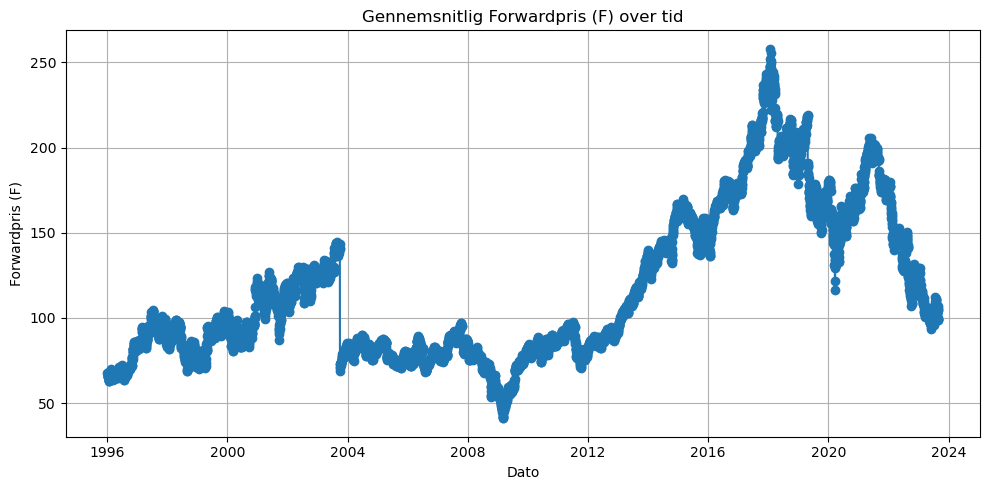

In [44]:
import matplotlib.pyplot as plt

# Beregn gennemsnitlig F per dag
avg_forward = od_debug.groupby("date")["F"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(avg_forward["date"], avg_forward["F"], marker='o')
plt.title("Gennemsnitlig Forwardpris (F) over tid")
plt.xlabel("Dato")
plt.ylabel("Forwardpris (F)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Section A

In [79]:
ticker_list = vp.DJX_tickers
sum_df = vtp.concat_ticker_datasets(ticker_list, "sum1")
# od_rdy = vtp.concat_output_ticker_datasets([ticker], "od_rdy")

Skipped 2/49 tickers: ['C', 'UK']


### figure 1 

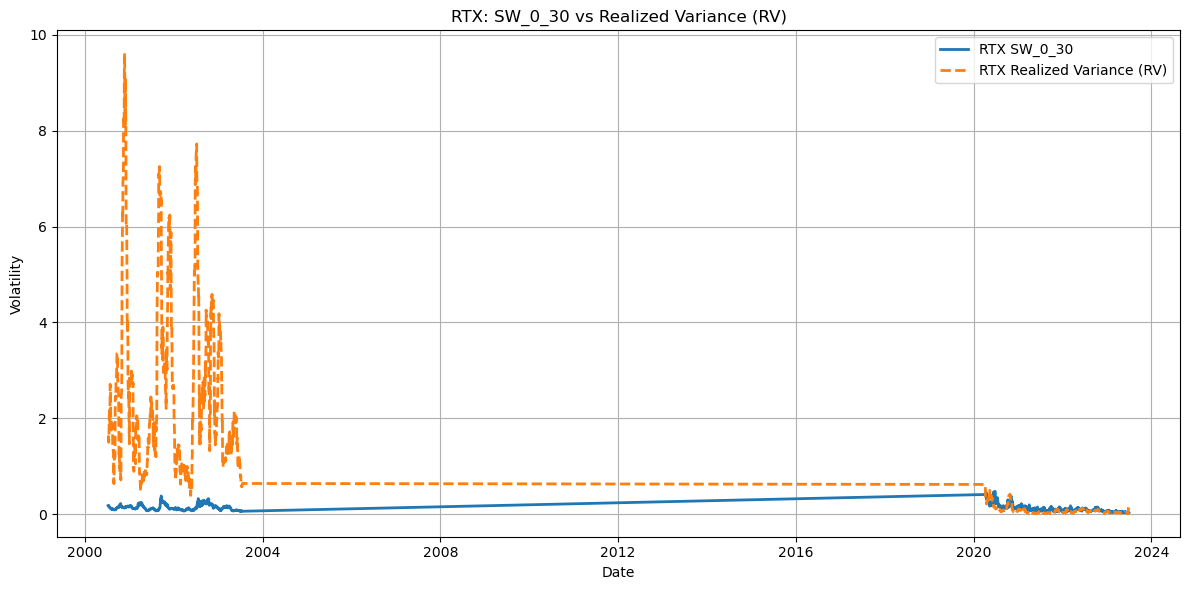

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_sw_vs_rv(dataframe, ticker, from_date="1996-01-01", to_date="2023-12-31"):
    df = dataframe.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.dropna(subset=["SW_0_30", "RV"])

    # Filtrér for ønsket ticker
    df = df[df["ticker"] == ticker]

    # Filtrér på datoer hvis angivet
    if from_date:
        from_date = pd.to_datetime(from_date)
        df = df[df['date'] >= from_date]
    if to_date:
        to_date = pd.to_datetime(to_date)
        df = df[df['date'] <= to_date]

    # Tjek for duplikate datoer og tag gennemsnit (valgfrit, men fornuftigt)
    df = df.groupby('date')[['SW_0_30', 'RV']].mean().reset_index()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["SW_0_30"], label=f"{ticker} SW_0_30", linewidth=2)
    plt.plot(df["date"], df["RV"], label=f"{ticker} Realized Variance (RV)", linewidth=2, linestyle='--')
    plt.title(f"{ticker}: SW_0_30 vs Realized Variance (RV)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_sw_vs_rv(sum_df, ticker="RTX", from_date="1996-01-01", to_date="2023-06-30")



### figure 2 initial 

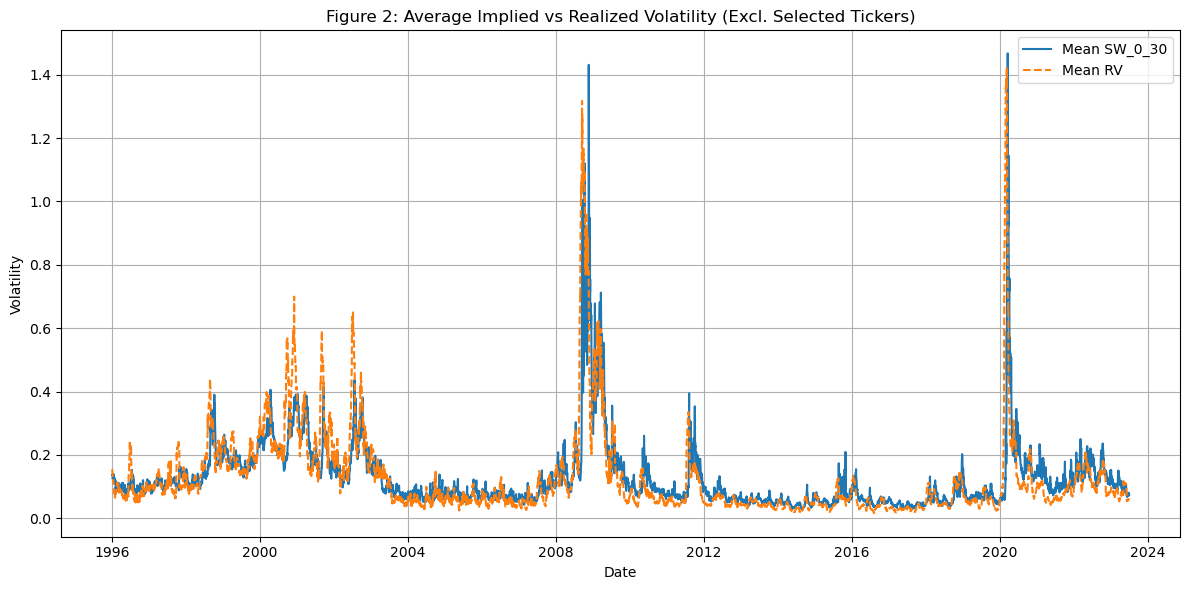

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_sw_vs_rv_excluding(dataframe, exclude_tickers=None, from_date="1996-01-01", to_date="2023-12-31"):
    df = dataframe.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.dropna(subset=["SW_0_30", "RV"])

    # Ekskludér angivne tickere
    if exclude_tickers:
        df = df[~df['ticker'].isin(exclude_tickers)]

    # Filtrér på datoer hvis angivet
    if from_date:
        from_date = pd.to_datetime(from_date)
        df = df[df['date'] >= from_date]
    if to_date:
        to_date = pd.to_datetime(to_date)
        df = df[df['date'] <= to_date]

    # Beregn gennemsnit pr. dato
    avg_sw = df.groupby("date")["SW_0_30"].mean()
    avg_rv = df.groupby("date")["RV"].mean()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(avg_sw.index, avg_sw.values, label="Mean SW_0_30")
    plt.plot(avg_rv.index, avg_rv.values, label="Mean RV", linestyle="--")
    plt.title("Figure 2: Average Implied vs Realized Volatility (Excl. Selected Tickers)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Udeluk DJX og HET fra gennemsnittet
plot_avg_sw_vs_rv_excluding(sum_df, exclude_tickers=["DJX"], from_date="1996-01-01", to_date="2023-06-30")


### merging SW and RV to return DF 

In [71]:
# Merge SW_0_30 fra sum_df over på final_df
final_df = daily_returns_constituents.merge(
    sum_df[["date", "ticker", "SW_0_30", "RV", "close"]],
    on=["date", "ticker"],
    how="left"
)

# (valgfrit) Tjek om der mangler noget
print(final_df.head(10))


        date ticker  weight_lag    return  SW_0_30  RV  close
0 1996-01-03     AA    0.037426  0.016092      NaN NaN    NaN
1 1996-01-03    AXP    0.028564  0.005422      NaN NaN    NaN
2 1996-01-03     BA    0.054977 -0.009390      NaN NaN    NaN
3 1996-01-03      C    0.038114  0.006772      NaN NaN    NaN
4 1996-01-03    CAT    0.040953  0.016807      NaN NaN    NaN
5 1996-01-03     DD    0.049557  0.003472      NaN NaN    NaN
6 1996-01-03    DIS    0.041900  0.006160      NaN NaN    NaN
7 1996-01-03     GE    0.050589  0.001701      NaN NaN    NaN
8 1996-01-03     GM    0.035963 -0.007177      NaN NaN    NaN
9 1996-01-03     GT    0.030887 -0.016713      NaN NaN    NaN


# creating final summary df to plot over time 

In [159]:
import pandas as pd

def calculate_summary_df(final_df, ticker_list):
    """
    Beregner equal- og cap-weighted gennemsnit af SW_0_30 og RV for en given liste af tickers.
    Returnerer en DataFrame med 'date' som almindelig kolonne og inkluderer Variance Risk Premium (VRP).
    """
    # Filtrer ønskede tickers
    filtered_df = final_df[final_df["ticker"].isin(ticker_list)]

    # Equal-weighted
    equal_weighted = (
        filtered_df.dropna(subset=["SW_0_30", "RV"])
        .groupby("date", as_index=False)
        .agg(
            SW_0_30_equalweight=("SW_0_30", "mean"),
            RV_equalweight=("RV", "mean"),
            n_tickers=("SW_0_30", "count")  # tæller hvor mange SW_0_30 der er
        )
    )

    # Cap-weighted
    cap_weighted = (
        filtered_df.dropna(subset=["SW_0_30", "RV"])
        .assign(
            weighted_sw=lambda x: x["SW_0_30"] * x["weight_lag"],
            weighted_rv=lambda x: x["RV"] * x["weight_lag"]
        )
        .groupby("date", as_index=False)
        .agg(
            SW_0_30_capweight=("weighted_sw", "sum"),
            RV_capweight=("weighted_rv", "sum")
        )
    )

    # Merge på 'date'
    summary_df = pd.merge(equal_weighted, cap_weighted, how="outer", on="date")
    summary_df = summary_df.sort_values("date")

    # Beregn VRP (kun hvor begge komponenter findes)
    summary_df["VRP_equalw"] = summary_df["SW_0_30_equalweight"] - summary_df["RV_equalweight"]
    summary_df["VRP_capw"] = summary_df["SW_0_30_capweight"] - summary_df["RV_capweight"]

    # Fjern rækker uden data i hovedkolonner
    summary_df = summary_df.dropna(how="all", subset=[
        "SW_0_30_equalweight",
        "RV_equalweight",
        "SW_0_30_capweight",
        "RV_capweight"
    ])

    return summary_df


sum_df_indexfiltered = calculate_summary_df(final_df, [t for t in vp.DJX_tickers if t != "RTX"])


### plotting over time eq weighted and cap weighted

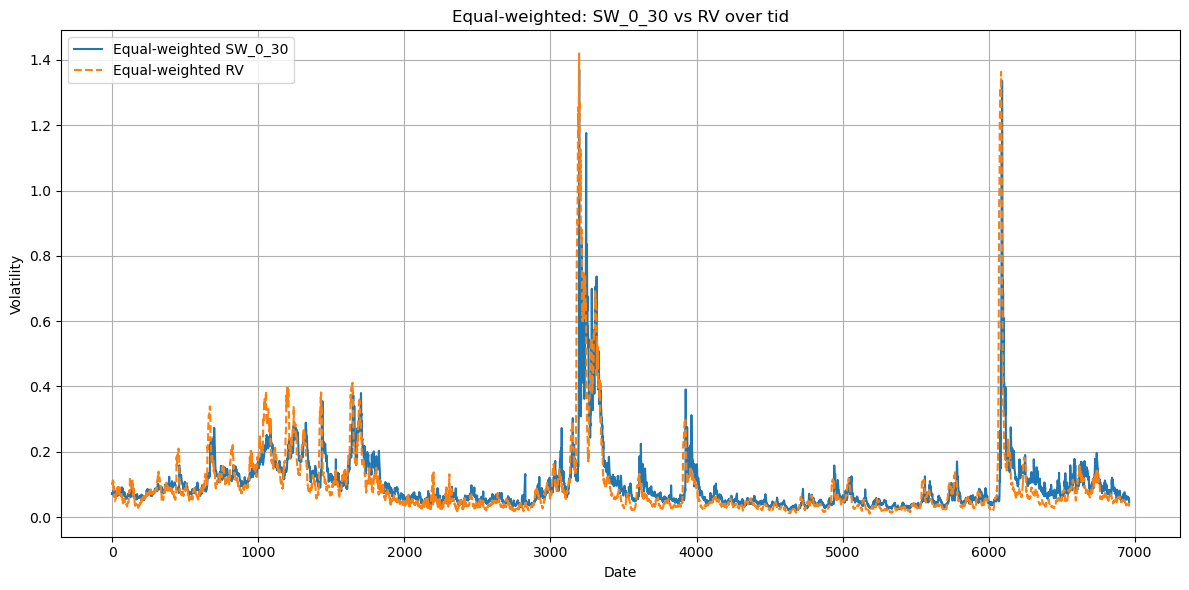

In [140]:
import matplotlib.pyplot as plt

# Plot Equal-weighted
plt.figure(figsize=(12, 6))
plt.plot(sum_df_indexfiltered.index, sum_df_indexfiltered["SW_0_30_equalweight"], label="Equal-weighted SW_0_30")
plt.plot(sum_df_indexfiltered.index, sum_df_indexfiltered["RV_equalweight"], label="Equal-weighted RV", linestyle="--")
plt.title("Equal-weighted: SW_0_30 vs RV over tid")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


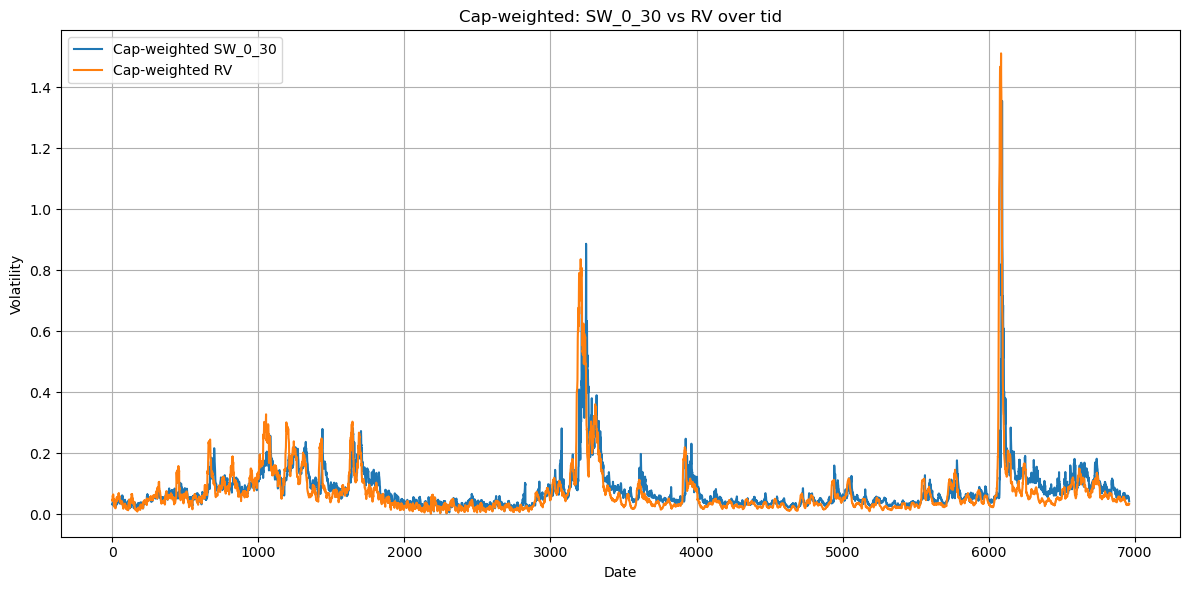

In [151]:
# Plot Cap-weighted
plt.figure(figsize=(12, 6))
plt.plot(sum_df_indexfiltered.index, sum_df_indexfiltered["SW_0_30_capweight"], label="Cap-weighted SW_0_30")
plt.plot(sum_df_indexfiltered.index, sum_df_indexfiltered["RV_capweight"], label="Cap-weighted RV", linestyle="-")
plt.title("Cap-weighted: SW_0_30 vs RV over tid")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### vrp average pr ticker

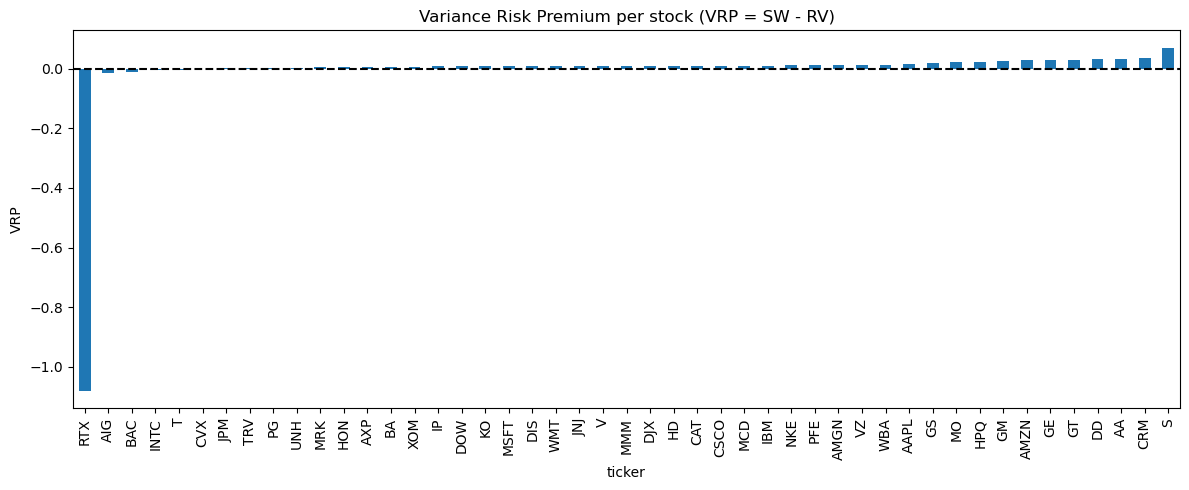

In [152]:
# Lav kopi og fjern NaN-værdier i både RV og SW_0_30
df_vrp = sum_df[["ticker", "date", "SW_0_30", "RV"]].copy()
df_vrp.dropna(subset=["SW_0_30", "RV"], inplace=True)

# Beregn MFIV, VRP og log-ratio
df_vrp["SW"] = df_vrp["SW_0_30"]
df_vrp["VRP"] = df_vrp["SW"] - df_vrp["RV"]

# Undgå division med nul eller negative værdier
df_vrp = df_vrp[(df_vrp["RV"] > 0) & (df_vrp["SW"] > 0)]
df_vrp["log_RV_SW"] = np.log(df_vrp["RV"] / df_vrp["SW"])

# Gennemsnit pr. ticker
vrp_per_stock = df_vrp.groupby("ticker")[["VRP", "log_RV_SW"]].mean().sort_values("VRP")

# Plot
plt.figure(figsize=(12, 5))
vrp_per_stock["VRP"].plot(kind="bar")
plt.axhline(0, color="black", linestyle="--")
plt.title("Variance Risk Premium per stock (VRP = SW - RV)")
plt.ylabel("VRP")
plt.tight_layout()
plt.show()


### table 1 (data to table 1)

In [143]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# Antag df_orpy eksisterer og har kolonnerne: 'ticker', 'date', 'SW_0_30', 'RV'
# 1. Beregn VRP
df_vrp = sum_df.copy()
df_vrp["VRP"] = df_vrp["SW_0_30"] - df_vrp["RV"]

# 2. T-test per ticker med Newey-West standard errors
result_rows = []

for ticker, group in df_vrp.groupby("ticker"):
    group = group.dropna(subset=["VRP"])

    if group.empty or len(group) < 30 or group["VRP"].isna().all():
        continue

    X = add_constant(pd.DataFrame(index=group.index))  
    y = group["VRP"].values

    model = OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 22})  # Newey-West standard errors

    t_stat = model.tvalues.iloc[0]
    p_value = model.pvalues.iloc[0]

    mean_vrp = group["VRP"].mean()

    result_rows.append({
        "ticker": ticker,
        "mean_vrp": mean_vrp,
        "t_stat": t_stat,
        "p_value": p_value,
        "n_obs": len(group)
    })

# 3. Konstruér resultater som DataFrame og sorter
df_vrp_test = pd.DataFrame(result_rows)
df_vrp_test = df_vrp_test.sort_values("p_value").reset_index(drop=True)

# Print resultater
print(df_vrp_test)


   ticker  mean_vrp    t_stat       p_value  n_obs
0     RTX -1.081781 -5.712082  1.116021e-08   1609
1     CRM  0.037478  5.141739  2.722070e-07   4657
2      MO  0.021682  5.059449  4.204695e-07   6808
3      VZ  0.013714  4.840282  1.296550e-06   5323
4      GE  0.029593  4.788715  1.678524e-06   6327
5     PFE  0.013126  4.606893  4.087309e-06   6214
6     MMM  0.010002  4.149325  3.334577e-05   6680
7     DJX  0.010446  3.747037  1.789354e-04   6511
8     JNJ  0.009715  3.725209  1.951538e-04   5950
9     IBM  0.011236  3.714267  2.037932e-04   6898
10    WMT  0.009294  3.456228  5.477909e-04   6380
11    CAT  0.010770  3.252536  1.143803e-03   6697
12    HPQ  0.023769  3.210020  1.327258e-03   4929
13    MCD  0.011145  3.196492  1.391097e-03   6101
14   AMGN  0.013334  3.195665  1.395090e-03   6775
15     GT  0.030594  2.978895  2.892895e-03   5051
16     KO  0.008121  2.970737  2.970859e-03   6111
17    NKE  0.012047  2.792298  5.233515e-03   6797
18     GS  0.018916  2.626663  

### table 1

In [103]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# Beregn VRP
df_vrp = sum_df.copy()
df_vrp["VRP"] = df_vrp["SW_0_30"] - df_vrp["RV"]

# Split: OEX vs øvrige
df_oex = df_vrp[df_vrp["ticker"] == "DJX"].dropna(subset=["SW_0_30", "RV"])
df_ind = df_vrp[df_vrp["ticker"] != "DJX"].dropna(subset=["SW_0_30", "RV"])

# Gennemsnit
mean_rv_oex = df_oex["RV"].mean()
mean_sw_oex = df_oex["SW_0_30"].mean()
mean_rv_ind = df_ind["RV"].mean()
mean_sw_ind = df_ind["SW_0_30"].mean()

# sqrt forskelle
sqrt_diff_oex = np.sqrt(mean_rv_oex) - np.sqrt(mean_sw_oex)
sqrt_diff_ind = np.sqrt(mean_rv_ind) - np.sqrt(mean_sw_ind)

# OLS tests med Newey-West
X_oex = add_constant(np.ones(len(df_oex)))
y_oex = df_oex["VRP"]
model_oex = OLS(y_oex, X_oex).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_vrp_eq_0_oex = model_oex.pvalues.iloc[0]

ratios_oex = df_oex["RV"] / df_oex["SW_0_30"]
ratios_oex = ratios_oex.replace([np.inf, 0], np.nan).dropna()
Xr_oex = add_constant(np.ones(len(ratios_oex)))
model_ratio_oex = OLS(ratios_oex - 1, Xr_oex).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_ratio_eq_1_oex = model_ratio_oex.pvalues.iloc[0]

X_ind = add_constant(np.ones(len(df_ind)))
y_ind = df_ind["VRP"]
model_ind = OLS(y_ind, X_ind).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_vrp_eq_0_ind = model_ind.pvalues.iloc[0]

ratios_ind = df_ind["RV"] / df_ind["SW_0_30"]
ratios_ind = ratios_ind.replace([np.inf, 0], np.nan).dropna()
Xr_ind = add_constant(np.ones(len(ratios_ind)))
model_ratio_ind = OLS(ratios_ind - 1, Xr_ind).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_ratio_eq_1_ind = model_ratio_ind.pvalues.iloc[0]

# Samlet tabel
summary_table = pd.DataFrame({
    "Category": [
        "Mean Realized Variance",
        "Mean Implied Variance (SW)",
        "Difference √RV − √SW",
        "p value for H₀: RV - SW = 0",
        "p value for H₀: RV / SW - 1 = 0"
    ],
    "Index Options (OEX)": [
        round(np.sqrt(mean_rv_oex), 6),
        round(np.sqrt(mean_sw_oex), 6),
        round(sqrt_diff_oex, 6),
        round(p_vrp_eq_0_oex, 6),
        round(p_ratio_eq_1_oex, 6)
    ],
    "Individual Options": [
        round(mean_rv_ind, 6),
        round(mean_sw_ind, 6),
        round(sqrt_diff_ind, 6),
        round(p_vrp_eq_0_ind, 6),
        round(p_ratio_eq_1_ind, 6)
    ]
})

# Udskriv tabel
print("\nSummary Table (SW terminologi):\n")
print(summary_table.to_string(index=False, col_space=35))


# Antag df_vrp_test eksisterer fra tidligere (output fra OLS tests per ticker)

# Filtrér kun individuelle aktier (dvs. ekskluder "OEX")
df_vrp_individuals = df_vrp_test[df_vrp_test["ticker"] != "OEX"]

# Antal pr kategori
summary_test_counts = pd.DataFrame({
    "Hypothesis": [
        "H₀: RV - SW = 0 not rejected",
        "H₀: RV - SW ≤ 0 rejected",
        "H₀: RV - SW ≥ 0 rejected"
    ],
    "# Ind. Stocks": [
        (df_vrp_individuals["p_value"] > 0.05).sum(),
        (df_vrp_individuals["t_stat"] > 0).sum(),
        (df_vrp_individuals["t_stat"] < 0).sum()
    ]
})

# Udskriv
print("\nIndividual Tests of Variance Risk Premia:\n")
print(summary_test_counts.to_string(index=False, col_space=40))





Summary Table (SW terminologi):

                           Category                 Index Options (OEX)                  Individual Options
             Mean Realized Variance                            0.187726                            0.124104
         Mean Implied Variance (SW)                            0.213745                            0.127657
               Difference √RV − √SW                           -0.026020                           -0.005006
        p value for H₀: RV - SW = 0                            0.000179                            0.082559
    p value for H₀: RV / SW - 1 = 0                            0.000001                            0.000089

Individual Tests of Variance Risk Premia:

                              Hypothesis                            # Ind. Stocks
            H₀: RV - SW = 0 not rejected                                       23
                H₀: RV - SW ≤ 0 rejected                                       41
                H₀: RV - SW 

# Section 3.B

In [163]:
def merge_single_ticker_into_summary(sum_df_indexfiltered, sum_df, ticker_name):
    """
    Filtrerer sum_df for én ticker, og merger SW_0_30 og RV ind i sum_df_indexfiltered baseret på dato.
    Kolonner omdøbes til fx Market_SW, Market_RV, og Market_VRP.
    Fjerner rækker hvor Market_SW eller Market_RV mangler.
    """
    # Filtrer for den ønskede ticker
    df_ticker = sum_df[sum_df["ticker"] == ticker_name][["date", "SW_0_30", "RV"]].copy()

    # Omdøb kolonner
    df_ticker = df_ticker.rename(columns={
        "SW_0_30": "Market_SW",
        "RV": "Market_RV"
    })

    # Merge ind i indexfiltered-data
    merged_df = pd.merge(
        sum_df_indexfiltered,
        df_ticker,
        on="date",
        how="left"
    )

    # Beregn VRP for tickeren
    merged_df["Market_VRP"] = merged_df["Market_SW"] - merged_df["Market_RV"]

    # Fjern rækker hvor market-data mangler
    merged_df = merged_df.dropna(subset=["Market_SW", "Market_RV"])

    return merged_df



sum_df_merged = merge_single_ticker_into_summary(
    sum_df_indexfiltered=sum_df_indexfiltered,
    sum_df=sum_df,
    ticker_name="DJX"
)



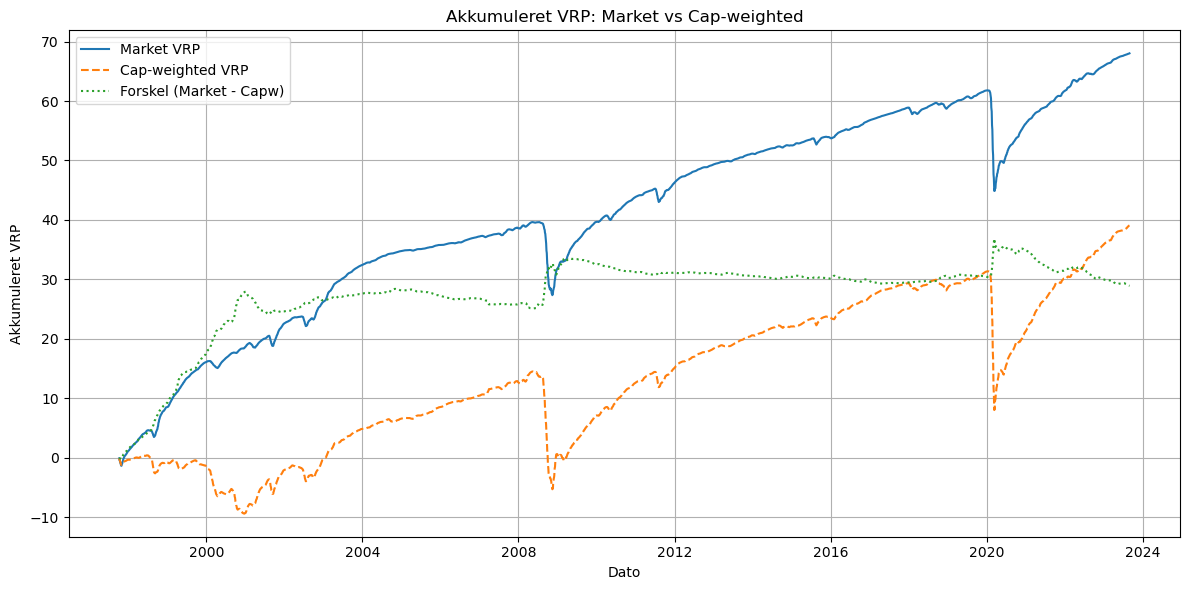

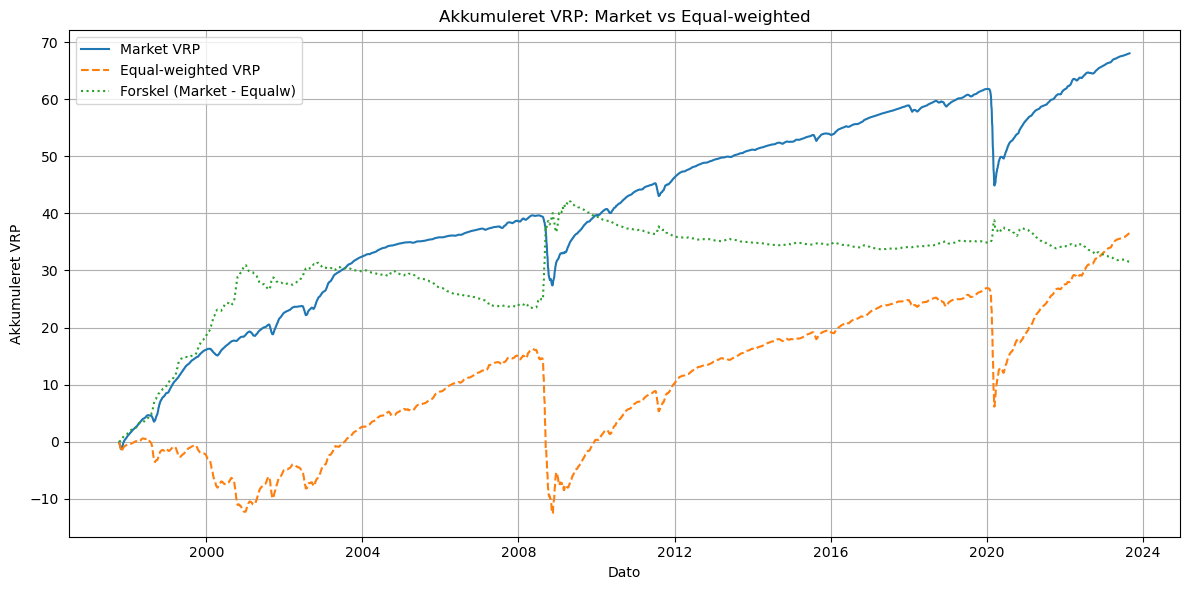

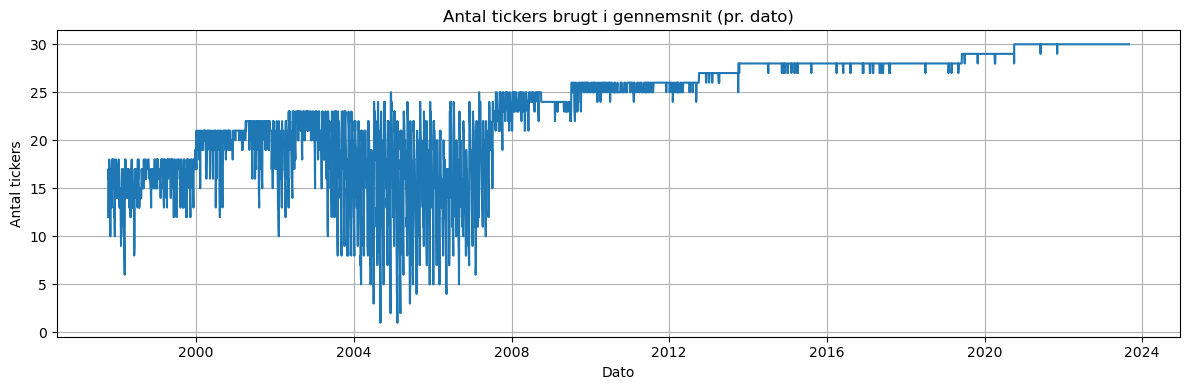

In [313]:
import matplotlib.pyplot as plt

def plot_cumulative_vrp(summary_df):
    # Sørg for sortering
    summary_df = summary_df.sort_values("date")

    # Beregn akkumuleret VRP
    summary_df["VRP_capw_cum"] = summary_df["VRP_capw"].cumsum()
    summary_df["VRP_equalw_cum"] = summary_df["VRP_equalw"].cumsum()
    summary_df["Market_VRP_cum"] = summary_df["Market_VRP"].cumsum()

    summary_df["Diff_capw_cum"] = summary_df["Market_VRP_cum"] - summary_df["VRP_capw_cum"]
    summary_df["Diff_equalw_cum"] = summary_df["Market_VRP_cum"] - summary_df["VRP_equalw_cum"]

    # === Plot 1: Market vs Cap-weighted ===
    plt.figure(figsize=(12, 6))
    plt.plot(summary_df["date"], summary_df["Market_VRP_cum"], label="Market VRP", linestyle="-")
    plt.plot(summary_df["date"], summary_df["VRP_capw_cum"], label="Cap-weighted VRP", linestyle="--")
    plt.plot(summary_df["date"], summary_df["Diff_capw_cum"], label="Forskel (Market - Capw)", linestyle=":")
    plt.title("Akkumuleret VRP: Market vs Cap-weighted")
    plt.xlabel("Dato")
    plt.ylabel("Akkumuleret VRP")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot 2: Market vs Equal-weighted ===
    plt.figure(figsize=(12, 6))
    plt.plot(summary_df["date"], summary_df["Market_VRP_cum"], label="Market VRP", linestyle="-")
    plt.plot(summary_df["date"], summary_df["VRP_equalw_cum"], label="Equal-weighted VRP", linestyle="--")
    plt.plot(summary_df["date"], summary_df["Diff_equalw_cum"], label="Forskel (Market - Equalw)", linestyle=":")
    plt.title("Akkumuleret VRP: Market vs Equal-weighted")
    plt.xlabel("Dato")
    plt.ylabel("Akkumuleret VRP")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot 3: Antal tickers over tid ===
    if "n_tickers" in summary_df.columns:
        plt.figure(figsize=(12, 4))
        plt.plot(summary_df["date"], summary_df["n_tickers"], label="Antal tickers", color="tab:blue")
        plt.title("Antal tickers brugt i gennemsnit (pr. dato)")
        plt.xlabel("Dato")
        plt.ylabel("Antal tickers")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


plot_cumulative_vrp(sum_df_merged)



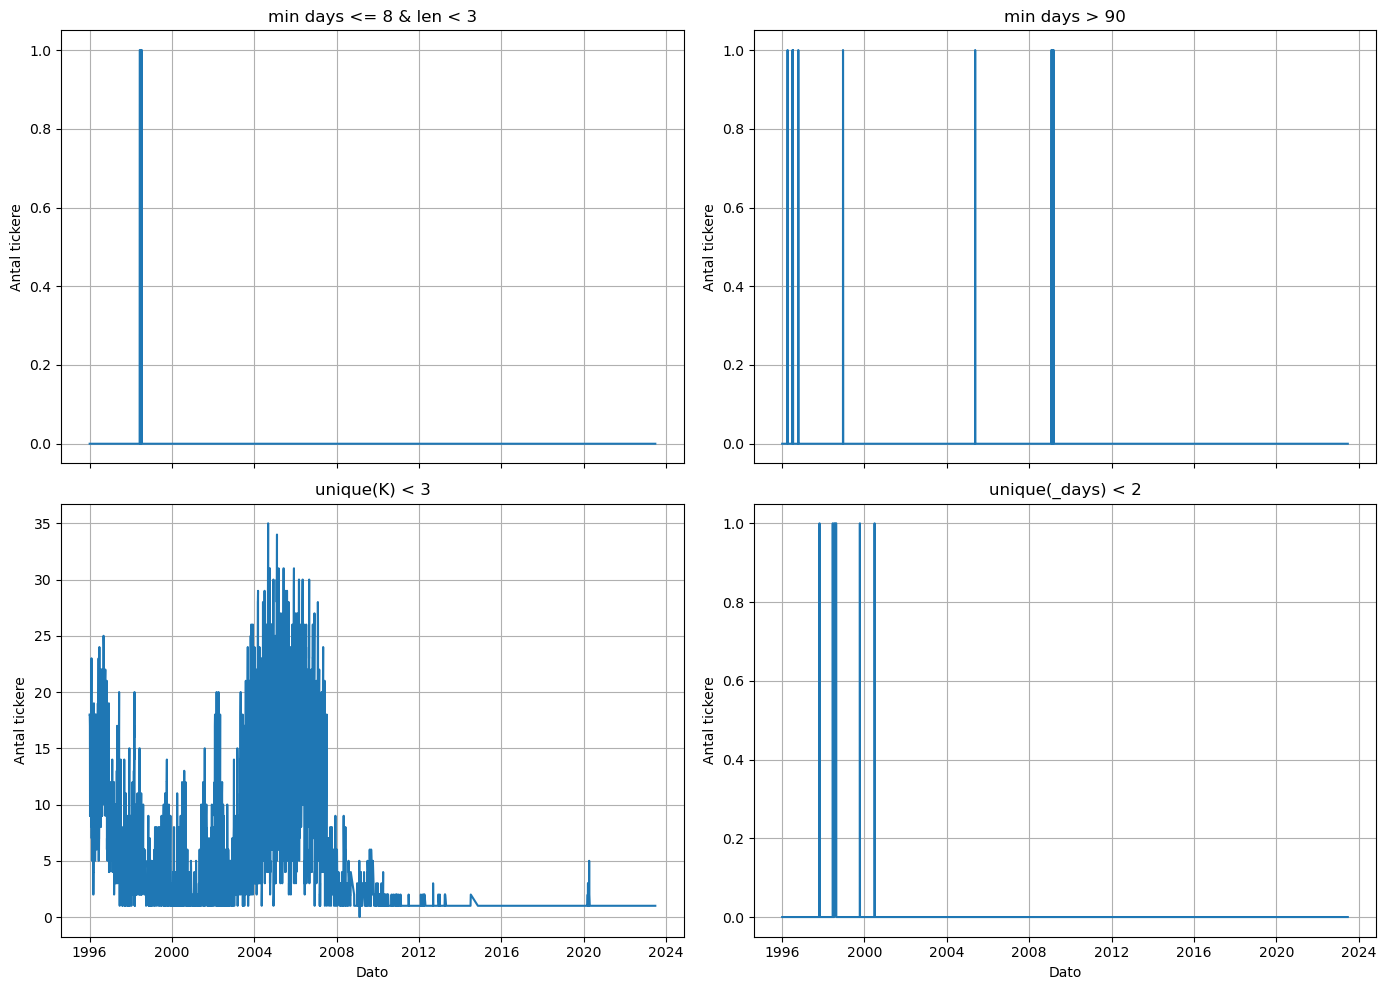

In [269]:
import matplotlib.pyplot as plt

def plot_inactive_reasons_over_time(sum_df):
    sum_df["date"] = pd.to_datetime(sum_df["date"])
    inactive_df = sum_df[sum_df["Active"] == 0]

    grouped = (
        inactive_df
        .groupby(["date", "Inactive reason"])
        .size()
        .reset_index(name="count")
    )

    pivot_df = (
        grouped
        .pivot(index="date", columns="Inactive reason", values="count")
        .fillna(0)
        .sort_index()
    )

    # Setup 2x2 subplots
    reasons = pivot_df.columns
    n_reasons = len(reasons)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    axes = axes.flatten()

    for i, reason in enumerate(reasons):
        ax = axes[i]
        ax.plot(pivot_df.index, pivot_df[reason])
        ax.set_title(reason)
        ax.set_ylabel("Antal tickere")
        ax.grid(True)

    # Fælles X-label på nederste række
    for ax in axes[-2:]:
        ax.set_xlabel("Dato")

    # Fjern evt. tomme subplot hvis færre end 4 årsager
    for j in range(n_reasons, 4):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return pivot_df

pivot_counts = plot_inactive_reasons_over_time(sum_df)


In [315]:
sum_df_ticker = vtp.concat_ticker_datasets(['IP', 'IBM', 'GE', 'UNH', 'BA', 'AAPL', 'DJX', 'MSFT'], "sum1")

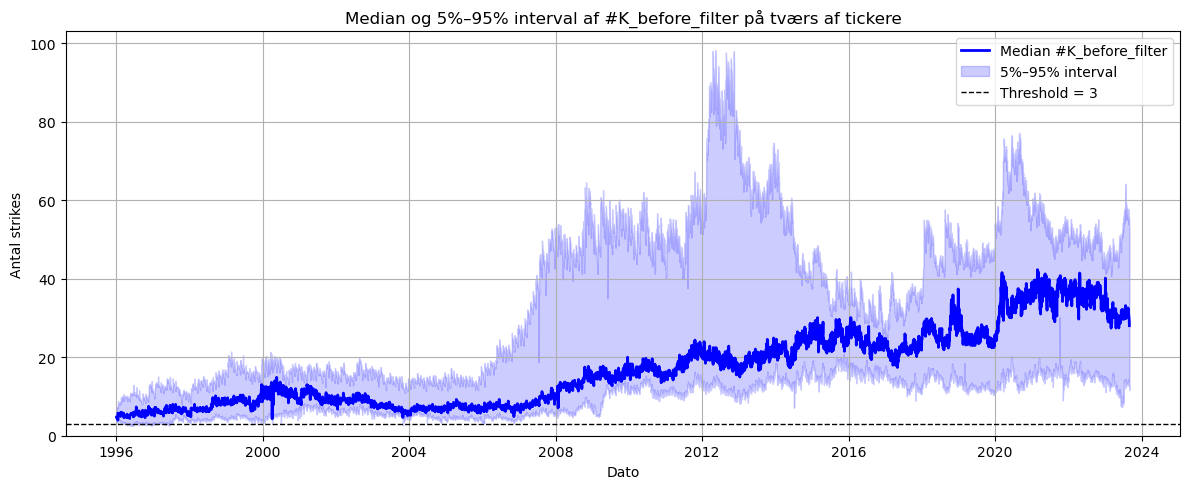

In [316]:
import matplotlib.pyplot as plt
import numpy as np

def plot_median_k_with_percentile_band(sum_df):
    """
    Plotter median af #K_before_filter med 5%-95% intervalbånd over tid.
    """
    sum_df["date"] = pd.to_datetime(sum_df["date"])
    df = sum_df.dropna(subset=["#K_before_filter"])

    # Beregn percentiler pr. dato
    percentile_df = (
        df.groupby("date")["#K_before_filter"]
        .agg(
            p5=lambda x: np.percentile(x, 5),
            median="median",
            p95=lambda x: np.percentile(x, 95)
        )
        .reset_index()
    )

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(percentile_df["date"], percentile_df["median"], color="blue", label="Median #K_before_filter", linewidth=2)
    plt.fill_between(percentile_df["date"], percentile_df["p5"], percentile_df["p95"], color="blue", alpha=0.2, label="5%–95% interval")
    plt.axhline(3, color="black", linestyle="--", linewidth=1, label="Threshold = 3")

    plt.ylim(bottom=0)
    plt.title("Median og 5%–95% interval af #K_before_filter på tværs af tickere")
    plt.xlabel("Dato")
    plt.ylabel("Antal strikes")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_median_k_with_percentile_band(sum_df_ticker)



# Section 4.A trading strategy

### create rollnig correlation estimate

In [132]:
import pandas as pd
import numpy as np

sum_df_filtered = sum_df[sum_df['ticker'] != 'OEX'].copy()
sum_df_filtered.loc[:, 'date'] = pd.to_datetime(sum_df_filtered['date'])
pivot_df = sum_df_filtered.pivot(index='date', columns='ticker', values='return')
pivot_df = pivot_df.sort_index()

rolling_avg_corr = []
window = 30

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    corr_matrix = window_returns.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    avg_corr = upper_triangle.stack().mean()
    rolling_avg_corr.append((pivot_df.index[i], avg_corr))

avg_corr_df = pd.DataFrame(rolling_avg_corr, columns=['date', 'avg_correlation'])


# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plt.plot(avg_corr_df['date'], avg_corr_df['avg_correlation'])
# plt.title('30-dages gennemsnitlig korrelation over tid')
# plt.xlabel('Dato')
# plt.ylabel('Gennemsnitlig korrelation')
# plt.grid(True)
# plt.tight_layout()
# plt.show()



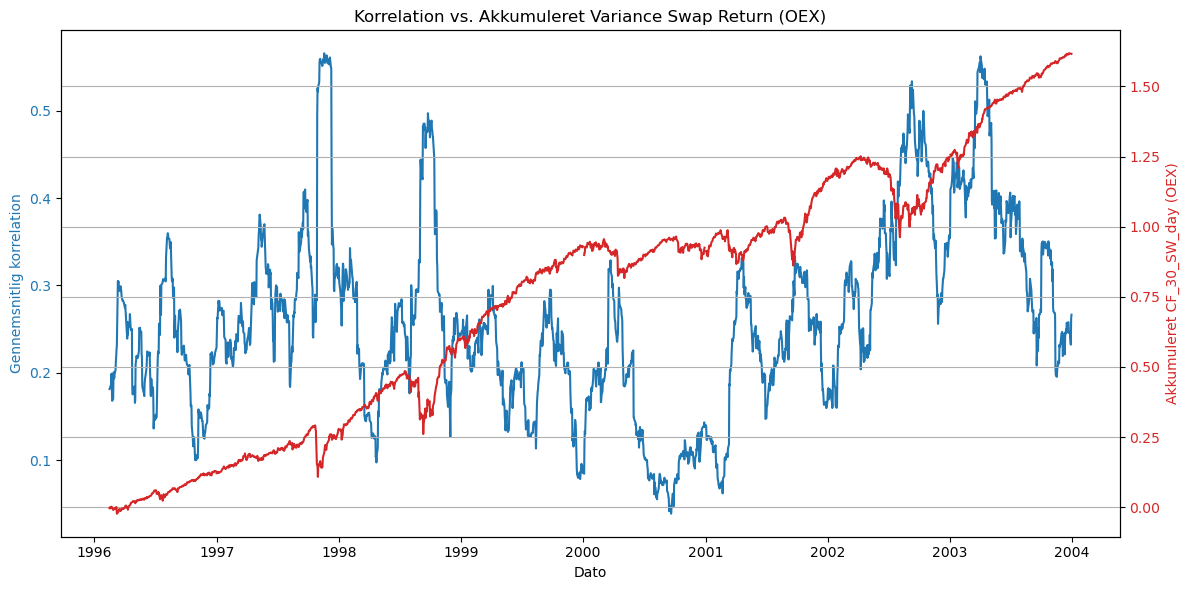

In [133]:
import matplotlib.pyplot as plt

# Filtrér for OEX og forbered data
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()
oex_df = oex_df.sort_values("date")
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Merge OEX og korrelationer på dato
merged_df = pd.merge(avg_corr_df, oex_df[["date", "cum_CF_30_SW_day"]], on="date", how="inner")

# Plot med to akser
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Gennemsnitlig korrelation", color=color)
ax1.plot(merged_df["date"], merged_df["avg_correlation"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Akkumuleret CF_30_SW_day (OEX)", color=color)
ax2.plot(merged_df["date"], merged_df["cum_CF_30_SW_day"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Korrelation vs. Akkumuleret Variance Swap Return (OEX)")
fig.tight_layout()
plt.grid(True)
plt.show()


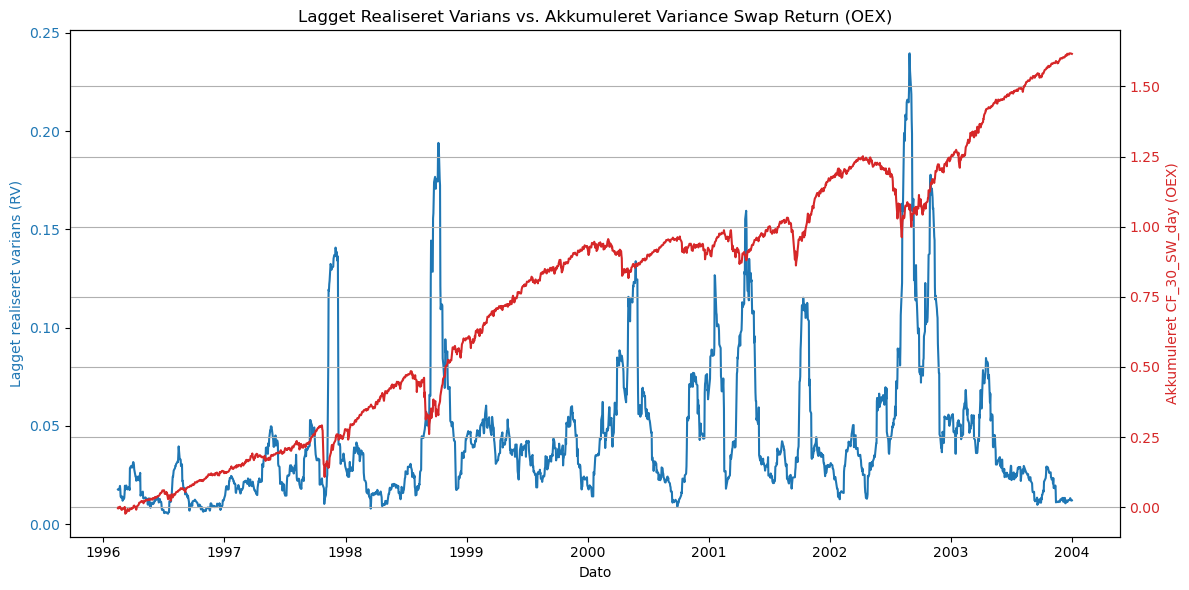

In [134]:
import matplotlib.pyplot as plt

# Filtrér for OEX og sorter
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()
oex_df = oex_df.sort_values("date")

# Lag realiseret varians 30 dage bagud
oex_df["RV_lagged"] = oex_df["RV"].shift(30)

# Beregn akkumuleret variance swap cashflow
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Drop NA (som kommer fra shift)
oex_df = oex_df.dropna(subset=["RV_lagged", "cum_CF_30_SW_day"])

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Lagget realiseret varians (RV)", color=color)
ax1.plot(oex_df["date"], oex_df["RV_lagged"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Akkumuleret CF_30_SW_day (OEX)", color=color)
ax2.plot(oex_df["date"], oex_df["cum_CF_30_SW_day"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Lagget Realiseret Varians vs. Akkumuleret Variance Swap Return (OEX)")
plt.grid(True)
fig.tight_layout()
plt.show()


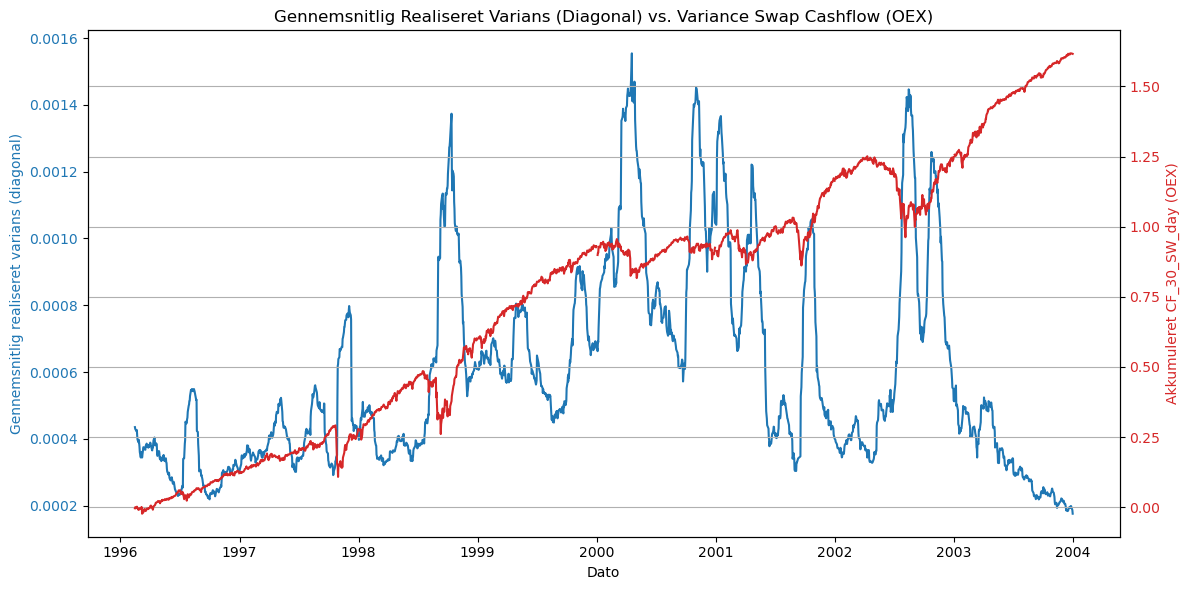

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filtrer OEX fra
returns_df = sum_df[sum_df["ticker"] != "OEX"].copy()
returns_df['date'] = pd.to_datetime(returns_df['date'])

# Pivotér til (dato × ticker) matrix
pivot_df = returns_df.pivot(index='date', columns='ticker', values='return')
pivot_df = pivot_df.sort_index()

# Beregn rullende gennemsnitlig diagonal (varians)
window = 30
avg_diag_variance = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    cov_matrix = window_returns.cov()
    diag_var = np.diag(cov_matrix)
    avg_var = np.nanmean(diag_var)
    avg_diag_variance.append((pivot_df.index[i], avg_var))

avg_var_df = pd.DataFrame(avg_diag_variance, columns=['date', 'avg_variance'])

# Forbered OEX cashflow
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()
oex_df = oex_df.sort_values("date")
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Merge begge tidsserier
merged_df = pd.merge(avg_var_df, oex_df[["date", "cum_CF_30_SW_day"]], on="date", how="inner")

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Gennemsnitlig realiseret varians (diagonal)", color=color)
ax1.plot(merged_df["date"], merged_df["avg_variance"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Akkumuleret CF_30_SW_day (OEX)", color=color)
ax2.plot(merged_df["date"], merged_df["cum_CF_30_SW_day"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Gennemsnitlig Realiseret Varians (Diagonal) vs. Variance Swap Cashflow (OEX)")
plt.grid(True)
fig.tight_layout()
plt.show()


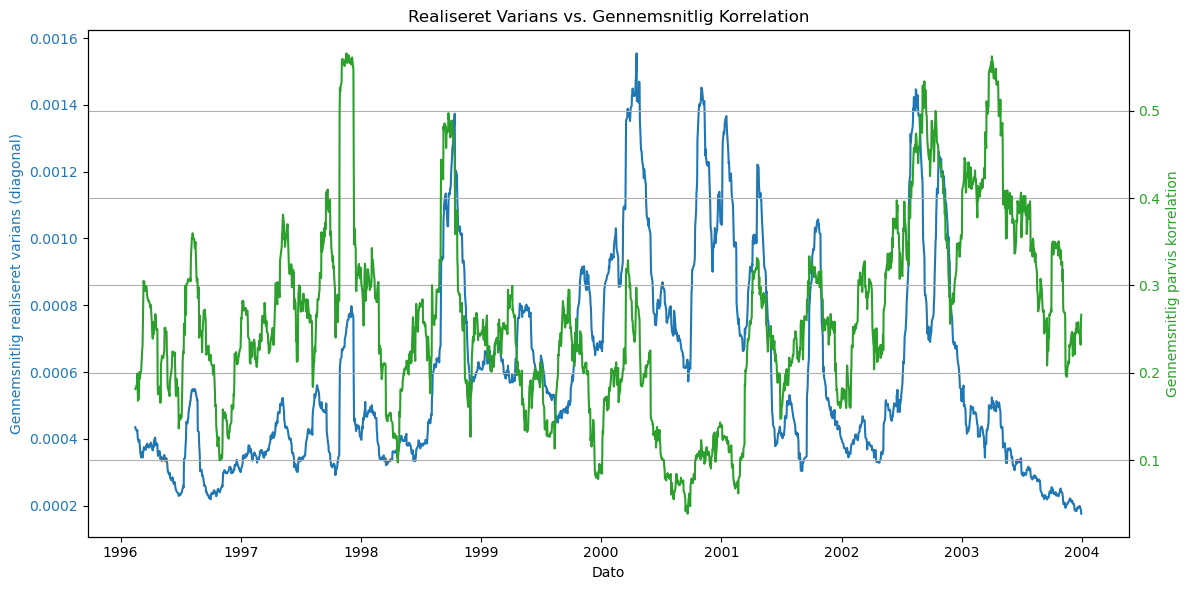

In [138]:
import matplotlib.pyplot as plt

# Merge realiseret varians og korrelation på dato
merged_metrics = pd.merge(avg_var_df, avg_corr_df, on='date', how='inner')

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Gennemsnitlig realiseret varians (diagonal)", color=color)
ax1.plot(merged_metrics["date"], merged_metrics["avg_variance"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("Gennemsnitlig parvis korrelation", color=color)
ax2.plot(merged_metrics["date"], merged_metrics["avg_correlation"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Realiseret Varians vs. Gennemsnitlig Korrelation")
plt.grid(True)
fig.tight_layout()
plt.show()


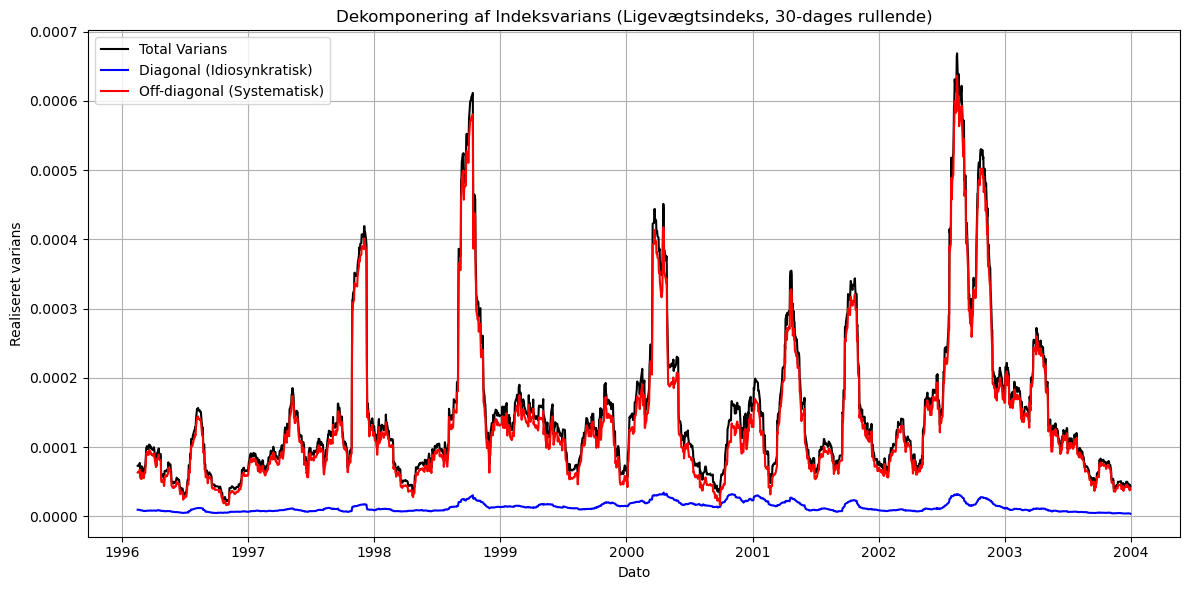

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Forbered data (ekskluder OEX)
returns_df = sum_df[sum_df["ticker"] != "OEX"].copy()
returns_df['date'] = pd.to_datetime(returns_df['date'])
pivot_df = returns_df.pivot(index='date', columns='ticker', values='return')
pivot_df = pivot_df.sort_index()

# Parametre
window = 30
decomp_data = []

# Loop over rullende vinduer
for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    cov_matrix = window_returns.cov()
    
    # Antal aktier i dette vindue (kan variere lidt pga. NaNs)
    tickers_in_window = cov_matrix.columns
    N = len(tickers_in_window)
    if N < 2:
        continue  # skip hvis for få data

    # Ligevægtsvægte
    w = np.ones(N) / N
    w_matrix = np.outer(w, w)

    # Total indeksvarians
    total_variance = np.sum(w_matrix * cov_matrix.values)

    # Diagonalbidrag (idiosynkratisk)
    diag = np.diag(cov_matrix.values)
    diag_variance = np.sum((w ** 2) * diag)

    # Off-diagonalbidrag
    off_diag_variance = total_variance - diag_variance

    # Gem resultat
    decomp_data.append((pivot_df.index[i], total_variance, diag_variance, off_diag_variance))

# Konverter til DataFrame
decomp_df = pd.DataFrame(decomp_data, columns=["date", "total", "diagonal", "off_diagonal"])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(decomp_df["date"], decomp_df["total"], label="Total Varians", color="black")
plt.plot(decomp_df["date"], decomp_df["diagonal"], label="Diagonal (Idiosynkratisk)", color="blue")
plt.plot(decomp_df["date"], decomp_df["off_diagonal"], label="Off-diagonal (Systematisk)", color="red")
plt.title("Dekomponering af Indeksvarians (Ligevægtsindeks, 30-dages rullende)")
plt.xlabel("Dato")
plt.ylabel("Realiseret varians")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


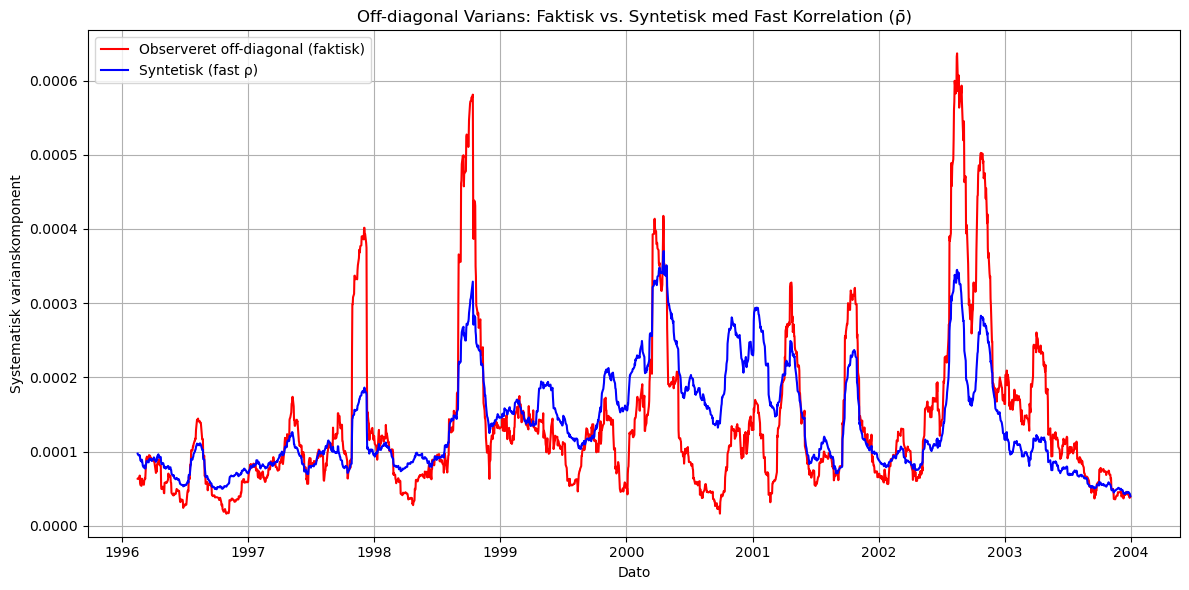

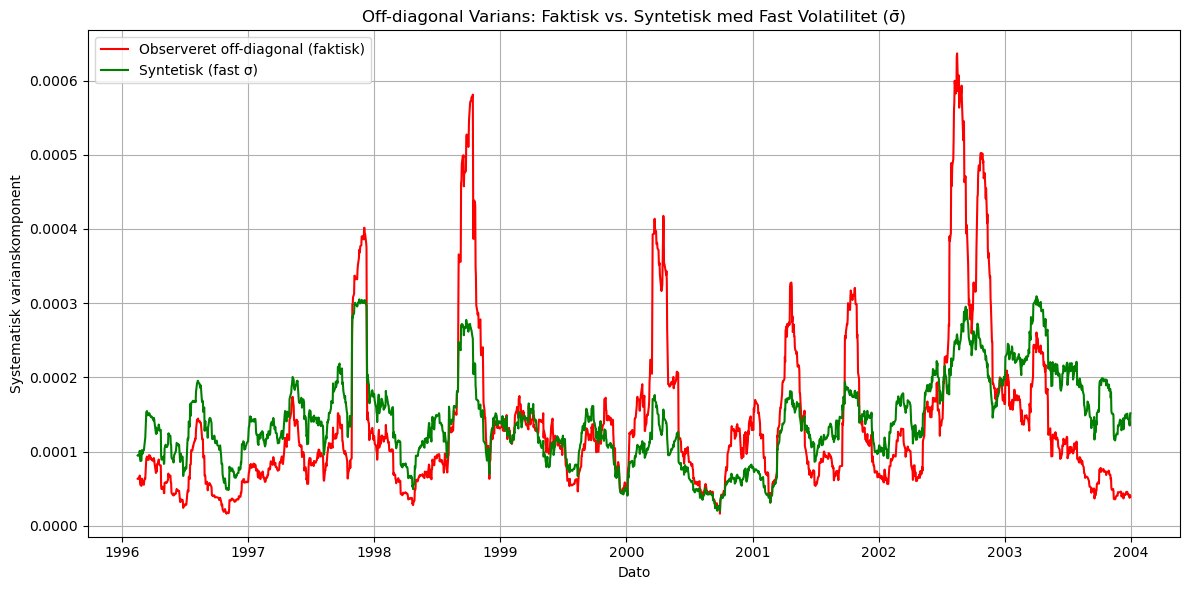

In [149]:
# Vælg om vi vil skalere syntetiske resultater
scale = False  # Sæt til True hvis du vil matche niveauer

# --------- Fast korrelation ---------
avg_rho = avg_corr_df["avg_correlation"].mean()
synthetic_off = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    cov_matrix = window_returns.cov()

    tickers = cov_matrix.columns
    N = len(tickers)
    if N < 2:
        continue

    sigmas = np.sqrt(np.diag(cov_matrix.values))
    rho_matrix = np.full((N, N), avg_rho)
    np.fill_diagonal(rho_matrix, 0)
    sigma_outer = np.outer(sigmas, sigmas)
    synthetic_cov_off = rho_matrix * sigma_outer

    w = np.ones(N) / N
    w_matrix = np.outer(w, w)
    off_diag_mask = ~np.eye(N, dtype=bool)
    weighted_synthetic_off = synthetic_cov_off * w_matrix * off_diag_mask

    synthetic_off_value = np.sum(weighted_synthetic_off)
    synthetic_off.append((pivot_df.index[i], synthetic_off_value))

synthetic_off_df = pd.DataFrame(synthetic_off, columns=["date", "synthetic_off"])
compare_df = pd.merge(decomp_df[["date", "off_diagonal"]], synthetic_off_df, on="date", how="inner")

if scale:
    scaling_factor = (compare_df["off_diagonal"] / compare_df["synthetic_off"]).mean()
    compare_df["synthetic_plot"] = compare_df["synthetic_off"] * scaling_factor
else:
    compare_df["synthetic_plot"] = compare_df["synthetic_off"]

plt.figure(figsize=(12, 6))
plt.plot(compare_df["date"], compare_df["off_diagonal"], label="Observeret off-diagonal (faktisk)", color="red")
plt.plot(compare_df["date"], compare_df["synthetic_plot"], label="Syntetisk (fast ρ)", color="blue")
plt.title("Off-diagonal Varians: Faktisk vs. Syntetisk med Fast Korrelation (ρ̄)")
plt.xlabel("Dato")
plt.ylabel("Systematisk varianskomponent")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------- Fast sigma ---------
long_cov = pivot_df.cov()
avg_sigmas = pd.Series(np.sqrt(np.diag(long_cov)), index=long_cov.columns)

rho_only_off = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    corr_matrix = window_returns.corr()

    tickers = corr_matrix.columns
    N = len(tickers)
    if N < 2:
        continue

    sigmas_window = avg_sigmas.loc[tickers].values
    sigma_outer = np.outer(sigmas_window, sigmas_window)
    rho_matrix = corr_matrix.values.copy()
    np.fill_diagonal(rho_matrix, 0)

    w = np.ones(N) / N
    w_matrix = np.outer(w, w)
    off_diag_mask = ~np.eye(N, dtype=bool)
    synthetic_cov = rho_matrix * sigma_outer
    weighted_synthetic_off = synthetic_cov * w_matrix * off_diag_mask

    total_synthetic_off = np.sum(weighted_synthetic_off)
    rho_only_off.append((pivot_df.index[i], total_synthetic_off))

rho_only_df = pd.DataFrame(rho_only_off, columns=["date", "rho_only_off"])
compare_df_rho = pd.merge(decomp_df[["date", "off_diagonal"]], rho_only_df, on="date", how="inner")

if scale:
    scaling_rho = (compare_df_rho["off_diagonal"] / compare_df_rho["rho_only_off"]).mean()
    compare_df_rho["synthetic_plot"] = compare_df_rho["rho_only_off"] * scaling_rho
else:
    compare_df_rho["synthetic_plot"] = compare_df_rho["rho_only_off"]

plt.figure(figsize=(12, 6))
plt.plot(compare_df_rho["date"], compare_df_rho["off_diagonal"], label="Observeret off-diagonal (faktisk)", color="red")
plt.plot(compare_df_rho["date"], compare_df_rho["synthetic_plot"], label="Syntetisk (fast σ)", color="green")
plt.title("Off-diagonal Varians: Faktisk vs. Syntetisk med Fast Volatilitet (σ̄)")
plt.xlabel("Dato")
plt.ylabel("Systematisk varianskomponent")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


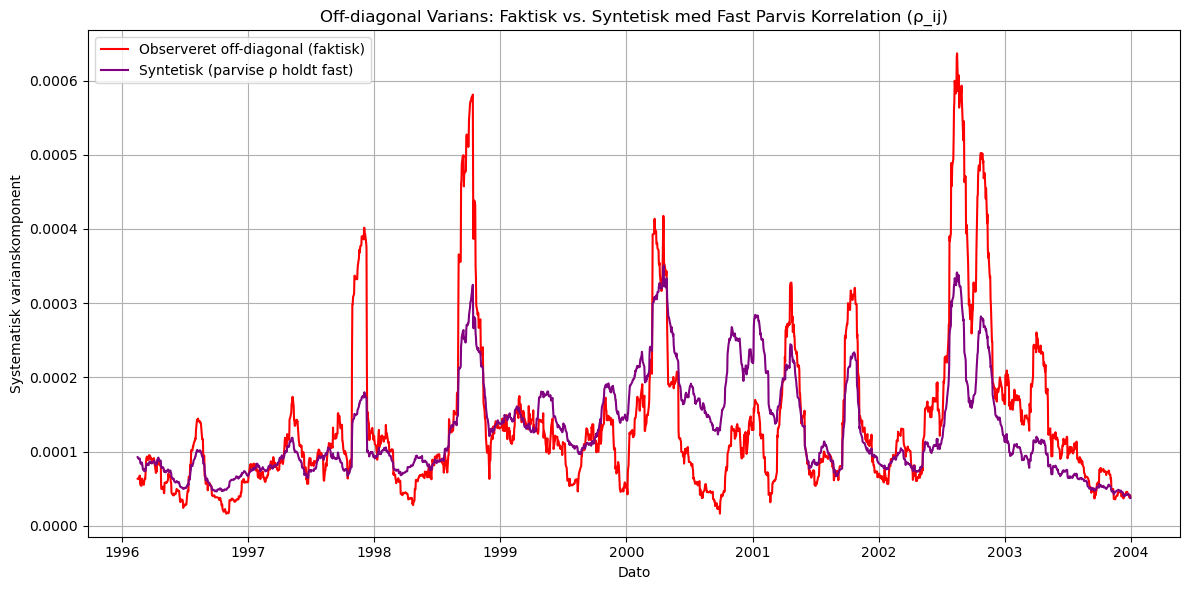

In [150]:
# Vælg om vi vil skalere syntetiske resultater
scale = False  # Sæt til True hvis du vil matche niveauer

# --------- Fast parvis korrelation (hele rho-matrix holdes fast) ---------

# Beregn gennemsnitlig korrelationsmatrix over hele perioden
full_corr = pivot_df.corr()
avg_corr_matrix = full_corr.values.copy()
np.fill_diagonal(avg_corr_matrix, 0)

synthetic_off_pairwise = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    tickers = window_returns.columns
    N = len(tickers)
    if N < 2:
        continue

    cov_matrix = window_returns.cov()
    sigmas = np.sqrt(np.diag(cov_matrix.values))

    # Udtræk kun den relevante del af avg_corr_matrix for aktuelle tickers
    idx = [pivot_df.columns.get_loc(t) for t in tickers]
    rho_matrix = avg_corr_matrix[np.ix_(idx, idx)]

    sigma_outer = np.outer(sigmas, sigmas)
    synthetic_cov_off = rho_matrix * sigma_outer

    w = np.ones(N) / N
    w_matrix = np.outer(w, w)
    off_diag_mask = ~np.eye(N, dtype=bool)
    weighted_synthetic_off = synthetic_cov_off * w_matrix * off_diag_mask

    synthetic_value = np.sum(weighted_synthetic_off)
    synthetic_off_pairwise.append((pivot_df.index[i], synthetic_value))

synthetic_pairwise_df = pd.DataFrame(synthetic_off_pairwise, columns=["date", "synthetic_off_pairwise"])
compare_df_pairwise = pd.merge(decomp_df[["date", "off_diagonal"]], synthetic_pairwise_df, on="date", how="inner")

if scale:
    scaling_pairwise = (compare_df_pairwise["off_diagonal"] / compare_df_pairwise["synthetic_off_pairwise"]).mean()
    compare_df_pairwise["synthetic_plot"] = compare_df_pairwise["synthetic_off_pairwise"] * scaling_pairwise
else:
    compare_df_pairwise["synthetic_plot"] = compare_df_pairwise["synthetic_off_pairwise"]

plt.figure(figsize=(12, 6))
plt.plot(compare_df_pairwise["date"], compare_df_pairwise["off_diagonal"], label="Observeret off-diagonal (faktisk)", color="red")
plt.plot(compare_df_pairwise["date"], compare_df_pairwise["synthetic_plot"], label="Syntetisk (parvise ρ holdt fast)", color="purple")
plt.title("Off-diagonal Varians: Faktisk vs. Syntetisk med Fast Parvis Korrelation (ρ_ij)")
plt.xlabel("Dato")
plt.ylabel("Systematisk varianskomponent")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


### trading strategy implement

In [ ]:
[ '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

# 0203524D = NSM
# NRTLQ = NT
# MTLQQ = GM
# LEHMQ = LEH
# NAN = NQN
# RSHCQ = RSH
# 987200Q = MAY
# 748957Q = PNU
# 653707Q = T
# 605555Q = S
# 3621240Q = ONE
# 3605818Q = HCA
# 3346Q = UBAN
# 2968900Q = IHRT
# 2258717D = EMC
# GBLXQ = GBLX
# ENRNQ = ENE
# EKDKQ = KODK
# DALRQ = DAL
# RTN/B = RTNB
# 1996074D = EP
# 3393199Q = BUD
# 1683997D = DELL
# 0848680D = FYBR
# 1255173D = WB
# 2071296D = NYX
# 1856613D = MON
# BRK/B = BRK
# 9903115D = CLB
# 1028411Q = G
# 1697067D = DOW
# 1715651D = DD
